## Import necessary packages

In [1]:
import numpy as np
import scipy.io
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import nibabel as nib
import os
import datetime
import time
import sys
import warnings
import glob
from scipy import stats
import seaborn as sns

code_folder = os.getcwd()
path_to_functions = os.path.join(code_folder, '..')
sys.path.insert(0, path_to_functions)
import functions as funcs
import importlib
importlib.reload(funcs)

from matplotlib.ticker import PercentFormatter
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

## Global variables

In [2]:
num_parcels = 116
num_cortical_parcels = 100

nodes = ['X%d'%i for i in range(1 , num_parcels+1 )]    # later you need to add the labels for each parcel: maybe the label of the brain structure where each parcel belongs to

tau_min = 0
tau_max = 3
    
pc_alpha = 1
alpha_level = 1e-2/32

num_subjects_ready = 200

num_networks = 16

network_dic = "{'LH_Vis':[],'LH_Som':[],'LH_Dor':[],'LH_Sal':[], 'LH_Lim':[], 'LH_Con':[], 'LH_Def':[], 'LH_Sub' :[], 'RH_Vis':[],'RH_Som':[],'RH_Dor':[],'RH_Sal':[], 'RH_Lim':[], 'RH_Con':[],'RH_Def':[], 'RH_Sub':[]}"
net_labels = ['LH_Vis','LH_Som','LH_Dor','LH_Sal', 'LH_Lim','LH_Con','LH_Def','LH_Sub', 'RH_Vis','RH_Som','RH_Dor','RH_Sal', 'RH_Lim', 'RH_Con', 'RH_Def', 'RH_Sub']

network_dic_v2 = "{'LH_Vis':[],'LH_Som':[],'LH_Dor':[],'LH_Sal':[], 'LH_Lim':[], 'LH_Con':[], 'LH_Def':[], 'RH_Vis':[],'RH_Som':[],'RH_Dor':[],'RH_Sal':[], 'RH_Lim':[], 'RH_Con':[],'RH_Def':[], 'RH_Sub':[], 'LH_Sub':[]}"
net_labels_v2 = ['LH_Vis','LH_Som','LH_Dor','LH_Sal', 'LH_Lim','LH_Con','LH_Def', 'RH_Vis','RH_Som','RH_Dor','RH_Sal', 'RH_Lim', 'RH_Con', 'RH_Def', 'RH_Sub','LH_Sub']


net_labels_visualization = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att', 'L-Lim','L-Cont','L-Def','L-Sub', 'R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att', 'R-Lim', 'R-Cont', 'R-Def', 'R-Sub']
visualization_labels = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att','L-Lim','L-Cont','L-Def','R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att','R-Lim','R-Cont','R-Def','R-Sub','L-Sub']


## Set the Path to External Packages and Files, Results, and Data

In [3]:
code_folder = os.getcwd()
files_folder = os.path.join(code_folder, '..', 'External Packages and Files')
results_folder = os.path.join(code_folder, '..', 'Results')
data_folder = os.path.join(code_folder, '..', 'Data')

# Read cortical and subcortical parcel labels

In [4]:
#Read cortical and subcortical parcel labels

df_cortical = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order.txt'), delimiter = '\t', header=None)
df_subcortical = pd.read_csv(os.path.join(files_folder, 'Tian_Subcortex_S1_3T_label.txt'), delimiter = '\t', header=None)

Schaefer2018_100Parcels_7Networks_labels = df_cortical[1]
Tian_Subcortex_S1_3T_labels = list(df_subcortical[0])

parcel_labels = []
parcel_labels_short = []

for i in range(0,num_parcels):
    if i < num_cortical_parcels:
        parcel_labels.append(Schaefer2018_100Parcels_7Networks_labels[i][10:])

    else:
        parcel_labels.append(Tian_Subcortex_S1_3T_labels[i-num_cortical_parcels])

    parcel_labels_short.append(parcel_labels[i][0:6])

# Standard Colors for Yeo2011 7 Networks

In [5]:
dataframe = pd.read_csv(os.path.join(files_folder, 'Yeo2011_7Networks_ColorLUT.txt'), delimiter='\t')
Yeo2011_7Networks_ColorLUT = np.array([[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78]])

# Parcel Indices in Each Subnetwork

In [6]:
num_networks = len(net_labels_v2)
num_parcels = len(parcel_labels)

network_parcel_idx = eval(network_dic_v2)

print(network_parcel_idx)
for i in range (0 , num_parcels):

    if i < num_cortical_parcels:
        temp = parcel_labels[i]
        temp_first = temp[0:6]
        if temp_first in network_parcel_idx:
            network_parcel_idx[temp_first].append(i)
    elif i >= num_cortical_parcels  and i<num_cortical_parcels +8:
        network_parcel_idx['RH_Sub'].append(i)
    
    else:
        network_parcel_idx['LH_Sub'].append(i)

{'LH_Vis': [], 'LH_Som': [], 'LH_Dor': [], 'LH_Sal': [], 'LH_Lim': [], 'LH_Con': [], 'LH_Def': [], 'RH_Vis': [], 'RH_Som': [], 'RH_Dor': [], 'RH_Sal': [], 'RH_Lim': [], 'RH_Con': [], 'RH_Def': [], 'RH_Sub': [], 'LH_Sub': []}


# Cortical and subcortical parcel coordinates

In [7]:
# cortical
cortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'))

cortical_parcel_locs_R = np.reshape(np.array(cortical_parcel_locs_dataframe['R']), (num_cortical_parcels,1))
cortical_parcel_locs_A = np.reshape(np.array(cortical_parcel_locs_dataframe['A']),(num_cortical_parcels,1))
cortical_parcel_locs_S = np.reshape(np.array(cortical_parcel_locs_dataframe['S']), (num_cortical_parcels,1))
cortical_parcel_locs = np.concatenate((cortical_parcel_locs_R, cortical_parcel_locs_A, cortical_parcel_locs_S), axis = 1)

# subcortical
subcortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder,'Tian_Subcortex_S1_3T_COG.txt'), delimiter = '\t', header =  None)
subcortical_parcel_locs = np.array(subcortical_parcel_locs_dataframe)

parcel_locs = np.concatenate((cortical_parcel_locs, subcortical_parcel_locs), axis = 0)

In [8]:
parcel_distances = np.array(scipy.spatial.distance.cdist(parcel_locs, parcel_locs))

# HCP resting-state fMRI data

## Select subjects

In [9]:
subjs = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs']

num_subjects = len(subjs)
selected_subjects_name = []

for s in range(0, num_subjects):
    
    temp_subj = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs'][s][0]
    selected_subjects_name.append(temp_subj) 

print('Total number of subjects:', num_subjects)

Total number of subjects: 700


## Load behavioral data

In [10]:
behavioral_df = pd.read_csv(os.path.join(files_folder,'HCP_behavioral_data.csv'))

behavioral_subjects_name_list = list(behavioral_df['Subject'])
behavioral_subjects_age_list = list(behavioral_df['Age'])
behavioral_subjects_gender_list = list(behavioral_df['Gender'])

## Load preprocessed fMRI data

In [11]:
fmri_data_rest_1_RL = []
fmri_data_rest_2_RL = []

fmri_data_rest_1_LR = []
fmri_data_rest_2_LR = []

behavioral_selected_subjects_age = []
behavioral_selected_subjects_gender = []

for file in os.listdir(os.path.join(data_folder,'HCP')):
    if file.endswith(".npy"):
        path_to_data = os.path.join(os.path.join(data_folder,'HCP'), file)

        file_name_split = file[:-4].split('_')

        R_L = file_name_split[-1]
        Rest_1_2 = file_name_split[-2]
        subj_name = file_name_split[-3]

        if subj_name in selected_subjects_name:

            if (R_L == 'RL' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_RL.append(np.load(path_to_data).T)

                behavioral_subjects_idx = behavioral_subjects_name_list.index(int(subj_name))
                behavioral_selected_subjects_age.append(behavioral_subjects_age_list[behavioral_subjects_idx])
                behavioral_selected_subjects_gender.append(behavioral_subjects_gender_list[behavioral_subjects_idx])

            elif (R_L == 'RL' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_RL.append(np.load(path_to_data).T)
                
            elif (R_L == 'LR' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_LR.append(np.load(path_to_data).T)

            elif (R_L == 'LR' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_LR.append(np.load(path_to_data).T)
            
print('Number of RL, Rest 1:', len(fmri_data_rest_1_RL) )
print('Number of RL, Rest 2:', len(fmri_data_rest_2_RL) )
print('Number of LR, Rest 1:', len(fmri_data_rest_1_LR) )
print('Number of LR, Rest 2:', len(fmri_data_rest_2_LR) )

Number of RL, Rest 1: 700
Number of RL, Rest 2: 700
Number of LR, Rest 1: 700
Number of LR, Rest 2: 700


### Gender and Age distribution among 200 subjects

In [12]:
female_idx = np.where(np.array(behavioral_selected_subjects_gender[0:num_subjects_ready]) == 'F')[0]
male_idx = np.where(np.array(behavioral_selected_subjects_gender[0:num_subjects_ready]) == 'M')[0]
print('Number of female subjects:', female_idx.shape)
print('Number of male subjects:', male_idx.shape)

Number of female subjects: (106,)
Number of male subjects: (94,)


## Save/Load data

In [48]:
# np.savez(os.path.join(results_folder,'HCP_Rest_700_Subjects'),fmri_data_rest_1_RL = fmri_data_rest_1_RL, fmri_data_rest_2_RL = fmri_data_rest_2_RL, fmri_data_rest_1_LR = fmri_data_rest_1_LR,fmri_data_rest_2_LR = fmri_data_rest_2_LR, selected_subjects_name = selected_subjects_name )
funcs.import_npz(os.path.join(results_folder,'HCP_Rest_700_Subjects.npz'))

# Functional Connectivity

In [49]:
functional_connectivity_correlations = []
functional_connectivity_p_values = []

for s in range(0, num_subjects_ready):

    fmri_data = np.concatenate((fmri_data_rest_1_LR[s], fmri_data_rest_1_RL[s],fmri_data_rest_2_LR[s],fmri_data_rest_2_RL[s]), axis = 0)
    
    fc_p_values = np.zeros((num_parcels, num_parcels))
    fc_correlations = np.zeros((num_parcels, num_parcels))

    for i in range(0,num_parcels):
        for j in range(0, num_parcels):
            x = fmri_data[:,i]
            y = fmri_data[:,j]

            r = scipy.stats.pearsonr(x, y)
            fc_correlations[i,j] = r[0]
            fc_p_values[i,j] = r[1]

    functional_connectivity_correlations.append(fc_correlations)
    functional_connectivity_p_values.append(fc_p_values) 

In [50]:
fc_binarized_all = []
fc_graph_density = []
plt.figure(figsize = (5,5))
fc_threshold = 0.01

degree_fc_parcel_level_all = []
degree_fc_sub_network_level_all = []
fc_all_networks_num_edges_from_to_individual_sub = np.zeros((num_networks, num_networks, num_subjects_ready))

for s in range(0,num_subjects_ready):

    fc_pvalues = functional_connectivity_p_values[s]
    fc_binarized = np.zeros_like(fc_pvalues)
    fc_binarized [fc_pvalues <= fc_threshold] = 1

    fc_binarized_all.append(fc_binarized)
    fc_graph_density.append(np.mean(fc_binarized))

    fc_all_networks_num_edges_from_to = funcs.network_map(fc_binarized,net_labels, network_dic, parcel_labels, num_cortical_parcels)
    fc_all_networks_num_edges_from_to_individual_sub[:,:,s] = fc_all_networks_num_edges_from_to

    degree_fc_sub_network_level_all.append(np.mean(fc_all_networks_num_edges_from_to, axis = 1))
    degree_fc_parcel_level_all.append(np.mean(fc_binarized, axis = 1))

<Figure size 500x500 with 0 Axes>

## Distribution of Functional Graph Density

Mean Graph Density: 0.7483516646848989


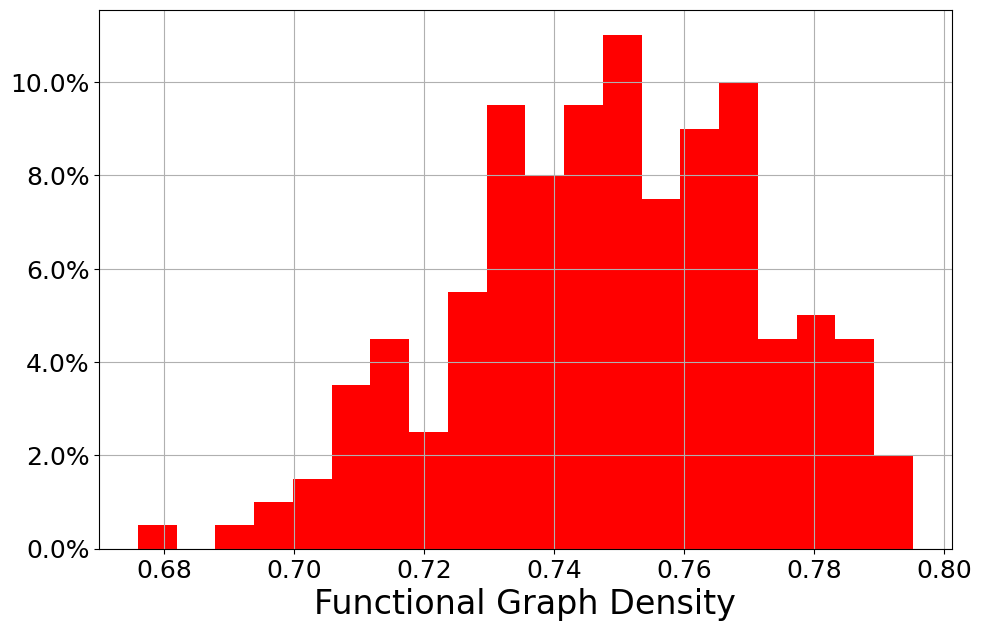

In [51]:
plt.figure(figsize = (11,7))
plt.hist(fc_graph_density, 20, weights=np.ones(len(fc_graph_density)) / len(fc_graph_density), color = 'red')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Functional Graph Density', fontsize = 24)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)

print('Mean Graph Density:', np.mean(fc_graph_density))    

# Causality Analysis

##  CaLLTiF Results on HCP Resting-State fMRI

### Load results

In [13]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle = True)
    for varName in Data:
        globals()[varName] = Data[varName]  

In [14]:
import_npz(os.path.join(results_folder,'multipledataset_calltif_hcp_rest.npz'))

In [15]:
time_series_graph_hcp_rest_all_subjects = []
time_series_graph_hcp_rest_all_subjects_pvalues = []

hcp_rest_all_graphs = []
hcp_rest_all_graphs_p_values = []

for s in range(0, num_subjects_ready):

    final_graph_org = multipledataset_calltif_hcp_rest_link_matrix[s]['graph']
    p_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['p_matrix'])
    
    # Threshold p_matrix to get graph
    final_graph_new = p_matrix <= alpha_level
    
    val_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['val_matrix'])
    _int_sel_links = multipledataset_calltif_hcp_rest_link_matrix[s]['_int_sel_links']

    # Convert to string graph representation
    graph = funcs.convert_to_string_graph(final_graph_new)

    # Time series graph
    time_series_graph_hcp_rest_all_subjects.append(graph)
    time_series_graph_hcp_rest_all_subjects_pvalues.append(p_matrix)

    # combined graph across lags
    summary_graph, binary_matrix , binary_matrix_p_value = funcs.summarize_across_all_lags_v2_with_pvalues(graph, p_matrix)
    
    hcp_rest_all_graphs.append(binary_matrix)
    hcp_rest_all_graphs_p_values.append(binary_matrix_p_value)

### Visualize the average and shared causal graphs

In [16]:
num_parcels_in_each_subnet = []

for a in network_parcel_idx:
    num_parcels_in_each_subnet.append(len(network_parcel_idx[a]))

print(num_parcels_in_each_subnet)

# just because R-sub and L-sub should be at the end
num_parcels_in_each_subnet = np.array([9, 6, 8, 7, 3, 4, 13, 8, 8, 7, 5, 2, 9, 11,8, 8])

print(num_parcels_in_each_subnet)

x_ticks_loc = np.cumsum(num_parcels_in_each_subnet)-num_parcels_in_each_subnet/2
print(x_ticks_loc)

y_ticks_loc = np.cumsum(num_parcels_in_each_subnet)-num_parcels_in_each_subnet/2
print(y_ticks_loc)

standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]]), np.array([[0, 0, 0]])), axis = 0)


[9, 6, 8, 7, 3, 4, 13, 8, 8, 7, 5, 2, 9, 11, 8, 8]
[ 9  6  8  7  3  4 13  8  8  7  5  2  9 11  8  8]
[  4.5  12.   19.   26.5  31.5  35.   43.5  54.   62.   69.5  75.5  79.
  84.5  94.5 104.  112. ]
[  4.5  12.   19.   26.5  31.5  35.   43.5  54.   62.   69.5  75.5  79.
  84.5  94.5 104.  112. ]


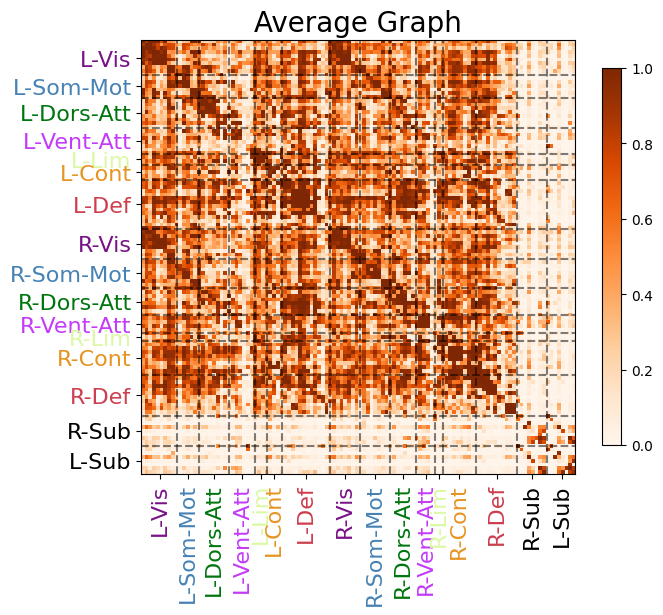

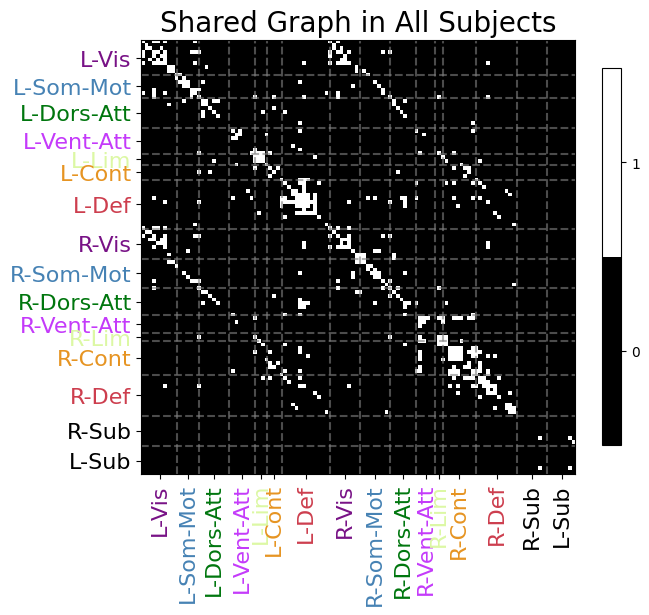

In [17]:
avg_graph = np.mean(np.array(hcp_rest_all_graphs), axis = 0)

plt.figure(figsize = (7,7))
plt.imshow(avg_graph, cmap = 'Oranges')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.colorbar(location = 'right', shrink = 0.7)
plt.title('Average Graph', fontsize = 20)

plt.xticks(x_ticks_loc, visualization_labels, rotation = 'vertical')

i = 0
# Set the individual tick colors
for tick_label in plt.gca().get_xticklabels():
    tick_label.set_color(standard_colors[i,:])
    i = i + 1

plt.yticks(y_ticks_loc, visualization_labels, rotation = 'horizontal')
i = 0
# Set the individual tick colors
for tick_label in plt.gca().get_yticklabels():
    tick_label.set_color(standard_colors[i,:])
    i = i + 1

dashed_line_locs = np.cumsum(num_parcels_in_each_subnet)

for i in range(0, len(dashed_line_locs)-1):
    plt.axvline(x=dashed_line_locs[i], color='black', linestyle='dashed', alpha=0.5)
    plt.axhline(y=dashed_line_locs[i], color='black', linestyle='dashed', alpha=0.5)


cmap = ListedColormap([[0,0,0], [1,1,1]])
plt.figure(figsize = (7,7))
threshold = 1
avg_graph_binarized = np.zeros_like(avg_graph) 
avg_graph_binarized[avg_graph <  threshold] = 0
avg_graph_binarized[avg_graph >= threshold] = 1
plt.imshow(avg_graph_binarized, cmap = cmap)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

cb = plt.colorbar(ticks=[0.25,.75], location = 'right', shrink = 0.7)
cb.set_ticklabels([0,1])

plt.title('Shared Graph in All Subjects', fontsize = 20)

plt.xticks(x_ticks_loc, visualization_labels, rotation = 'vertical')

i = 0
# Set the individual tick colors
for tick_label in plt.gca().get_xticklabels():
    tick_label.set_color(standard_colors[i,:])
    i = i + 1


plt.yticks(y_ticks_loc, visualization_labels, rotation = 'horizontal')
i = 0
# Set the individual tick colors
for tick_label in plt.gca().get_yticklabels():
    tick_label.set_color(standard_colors[i,:])
    i = i + 1

for i in range(0, len(dashed_line_locs)-1):
    plt.axvline(x=dashed_line_locs[i], color='gray', linestyle='dashed', alpha=0.6)
    plt.axhline(y=dashed_line_locs[i], color='gray', linestyle='dashed', alpha=0.6)

### Number of edges in the shared graph (with and without self-loops)

In [18]:
avg_graph = np.mean(np.array(hcp_rest_all_graphs), axis = 0)

threshold = 1
avg_graph_binarized = np.zeros_like(avg_graph) 
avg_graph_binarized[avg_graph <  threshold] = 0
avg_graph_binarized[avg_graph >= threshold] = 1

num_edge_including_self_loops = np.sum(avg_graph_binarized)

np.fill_diagonal(avg_graph_binarized, 0)
num_edge_without_self_loops = np.sum(avg_graph_binarized)

print('Total number of edges in the shared causal graph:',num_edge_including_self_loops)
print('Total number of edges in the shared causal graph excluding the self-loops:',num_edge_without_self_loops)

Total number of edges in the shared causal graph: 539.0
Total number of edges in the shared causal graph excluding the self-loops: 461.0


### Graph parameters for each subject

In [19]:
degree_centrality_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
betweenness_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
load_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
eigenvector_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))

out_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
in_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
causal_flow_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))

all_networks_num_edges_from_to_individual_sub = np.zeros((num_networks, num_networks, num_subjects_ready))

causal_flow_subnetworks = np.zeros((num_networks,num_subjects_ready))
degree_subnetworks = np.zeros((num_networks,num_subjects_ready))

all_features_parcels = [0]*num_subjects_ready
for s in range(num_subjects_ready):

    graph = hcp_rest_all_graphs[s]
    G = nx.DiGraph(graph)

    degree_centrality_all_parcels = list(nx.degree_centrality(G).values())
    betweenness_centrality_all_parcels = list(nx.betweenness_centrality(G).values())
    load_centrality_all_parcels = list(nx.load_centrality(G).values())
    eigenvector_centrality_all_parcels = list(nx.eigenvector_centrality(G).values())

    degree_centrality_all_parcels_individual_sub[:,s] = degree_centrality_all_parcels
    betweenness_centrality_all_parcels_individual_sub[:,s] = betweenness_centrality_all_parcels
    load_centrality_all_parcels_individual_sub[:,s] = load_centrality_all_parcels
    eigenvector_centrality_all_parcels_individual_sub[:,s] = eigenvector_centrality_all_parcels

    out_degree_all_parcels = np.mean(graph, axis = 1)
    in_degree_all_parcels = np.mean(graph, axis = 0)
    degree_all_parcels = out_degree_all_parcels + in_degree_all_parcels

    out_degree_all_parcels_individual_sub[:,s] = out_degree_all_parcels
    in_degree_all_parcels_individual_sub[:,s] = in_degree_all_parcels
    degree_all_parcels_individual_sub[:,s] = degree_all_parcels

    causal_flow_all_parcels_individual_sub[:,s] = out_degree_all_parcels - in_degree_all_parcels
    all_features_parcels[s] = np.concatenate((betweenness_centrality_all_parcels,degree_all_parcels,out_degree_all_parcels - in_degree_all_parcels))

    # look at the networks
    all_networks_num_edges_from_to = funcs.network_map(graph,net_labels, network_dic, parcel_labels, num_cortical_parcels)
    all_networks_num_edges_from_to_individual_sub[:,:,s] = all_networks_num_edges_from_to

    causal_flow_subnetworks[:,s] = np.mean(all_networks_num_edges_from_to,axis = 1)-np.mean(all_networks_num_edges_from_to, axis = 0)
    degree_subnetworks[:,s] = np.mean(all_networks_num_edges_from_to,axis = 1)+np.mean(all_networks_num_edges_from_to, axis = 0)

### Number of Edges From Each Lag


In [20]:
density_each_lag = [[0 for  j in range(0,num_subjects_ready )] for i in range(0,tau_max+1)]

for s in range(0,num_subjects_ready):
    for tau in range(0,tau_max+1):
        time_series_graph = time_series_graph_hcp_rest_all_subjects[s][:,:,tau]

        if tau == 0:
            num_edges_current_lag = np.where(time_series_graph_hcp_rest_all_subjects[s][:,:,tau] == 'o-o')[0].shape[0]

        else:
            num_edges_current_lag = np.where(time_series_graph_hcp_rest_all_subjects[s][:,:,tau] == '-->')[0].shape[0]

        density_each_lag[tau][s] = num_edges_current_lag/(num_parcels**2)

Text(0.5, 0, 'Graph Density')

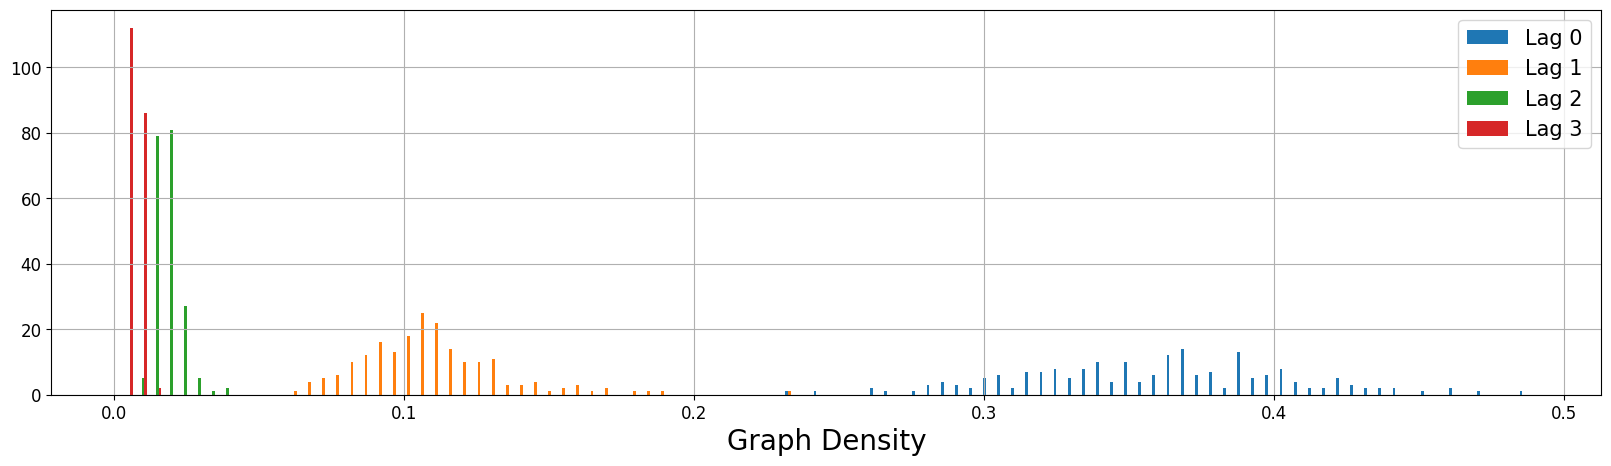

In [21]:
lag_labels = ['Lag 0','Lag 1','Lag 2', 'Lag 3']
plt.figure(figsize = (20,5))
p = plt.hist(density_each_lag, 100, label= lag_labels)
plt.xticks(fontsize = 12 )
plt.yticks(fontsize = 12 )

plt.legend(prop={'size': 15})
plt.grid()
plt.xlabel('Graph Density', fontsize = 20)

### Find Intersection Graph Among Lags

In [22]:
intersection_graph_all_lags_all_subjects = []
intersection_graph_all_lags_all_subjects_density = []
for s in range(0, num_subjects_ready):

    intersection_graph_all_lags = [[0 for  k in range(0,num_parcels)] for  j in range(0,num_parcels )]

    for i in range(0,num_parcels):
        for j in range(0,num_parcels):
            edges_in_all_lags = time_series_graph_hcp_rest_all_subjects[s][i,j,:]

            if '' not in edges_in_all_lags:
                intersection_graph_all_lags[i][j] = 1

    intersection_graph_all_lags_all_subjects.append(intersection_graph_all_lags)
    intersection_graph_all_lags_all_subjects_density.append (np.mean(intersection_graph_all_lags))

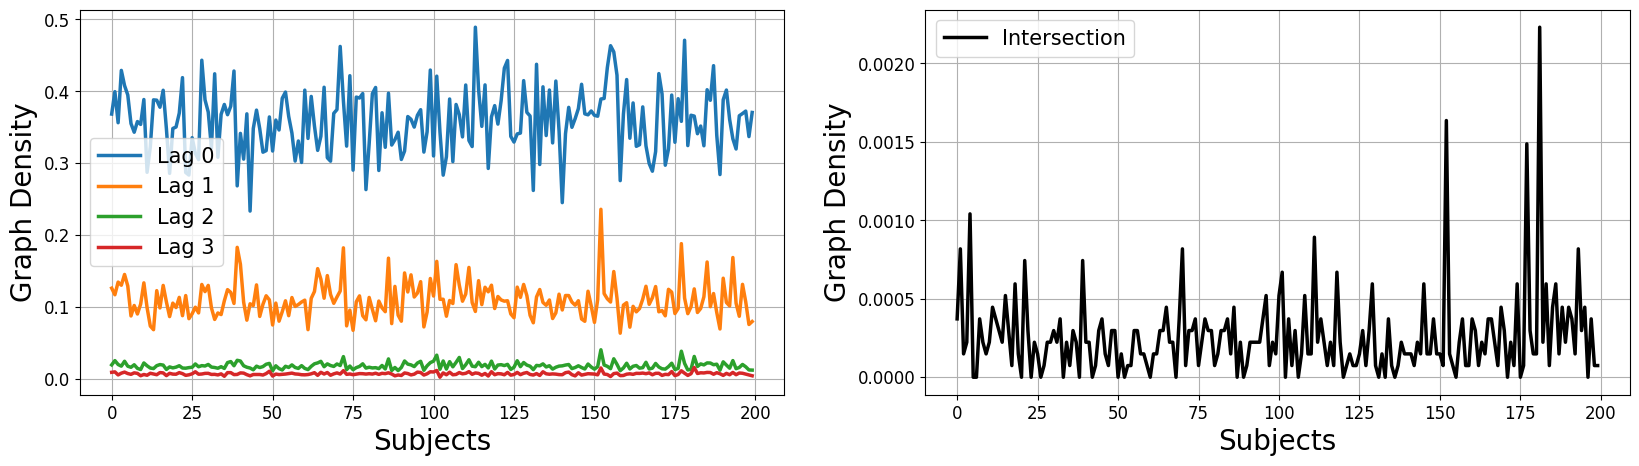

In [23]:
lag_labels = ['Lag 0','Lag 1','Lag 2','Lag 3']
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
p = plt.plot(np.array(density_each_lag).T, label= lag_labels, linewidth = 2.5)
plt.grid()
plt.ylabel('Graph Density', fontsize = 20)
plt.xlabel('Subjects', fontsize = 20)
plt.xticks(fontsize = 12 )
plt.yticks(fontsize = 12 )

plt.legend(fontsize = 15)

plt.subplot(1,2,2)

plt.plot(np.array(intersection_graph_all_lags_all_subjects_density), linewidth = 2.5, color = 'black', label = 'Intersection' )
plt.grid()
plt.ylabel('Graph Density', fontsize = 20)
plt.xlabel('Subjects', fontsize = 20)
plt.xticks(fontsize = 12 )
plt.yticks(fontsize = 12 )
plt.legend(fontsize = 15)


### Checking what percentage of edges come from each lag (the sum of percentages doesn’t need to be 100% due to the OR mechanism for keeping edges)

In [24]:
density_each_lag_only = [[0 for  j in range(0,num_subjects_ready )] for i in range(0,tau_max+1)]
each_lag_graph_all = [[0 for  j in range(0,num_subjects_ready )] for i in range(0,tau_max+1)]
for s in range(0,num_subjects_ready):
    for tau in range(0,tau_max+1):
        time_series_graph = time_series_graph_hcp_rest_all_subjects[s]

        temp = np.zeros((num_parcels,num_parcels))
        for i in range(0,num_parcels):
            for j in range(0,num_parcels):

                current_edge_all_lags = time_series_graph[i,j,:]
                current_edge_all_lags_except_tau = np.delete(current_edge_all_lags, tau)

                if tau != 0:
                    if (current_edge_all_lags[tau] == '-->') and ('-->' not in current_edge_all_lags_except_tau) and ('o-o' not in current_edge_all_lags_except_tau):
                        temp[i,j] = 1
                else:
                    if (current_edge_all_lags[tau] == 'o-o') and ('-->' not in current_edge_all_lags_except_tau):
                        temp[i,j] = 1
        each_lag_graph_all[tau][s] = temp
        density_each_lag_only[tau][s] = np.sum(temp)/np.sum(hcp_rest_all_graphs[s])


Text(0.5, 0, 'Percentage of edges come from each lag')

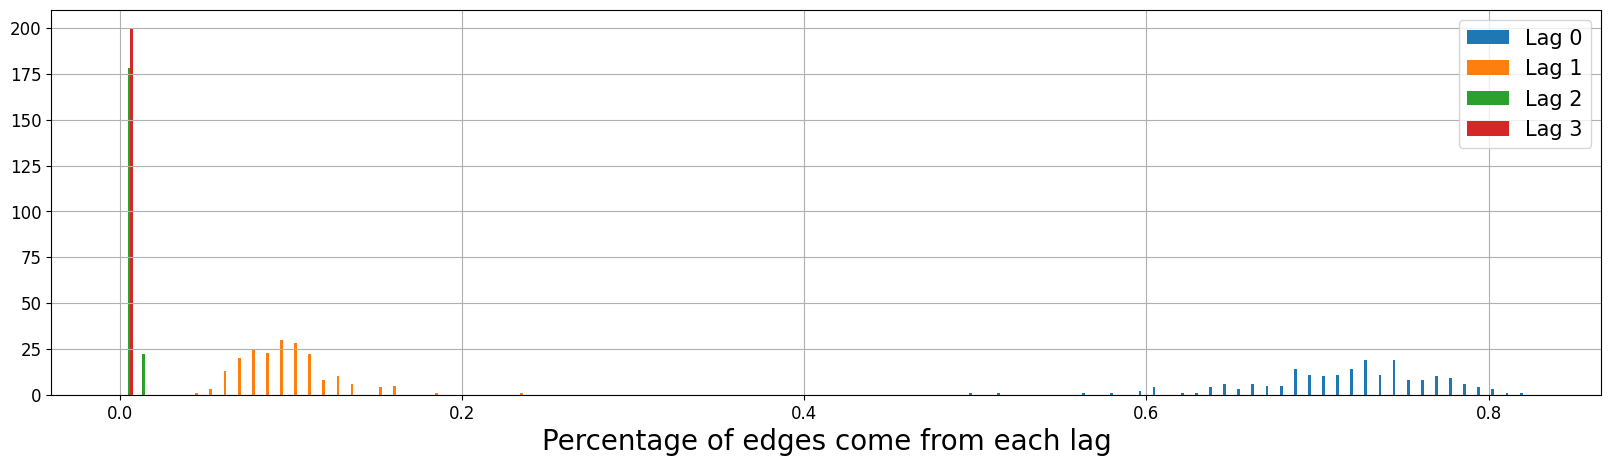

In [25]:
lag_labels = ['Lag 0','Lag 1','Lag 2', 'Lag 3']
plt.figure(figsize = (20,5))
p = plt.hist(density_each_lag_only, 100, label= lag_labels)
plt.xticks(fontsize = 12 )
plt.yticks(fontsize = 12 )

plt.legend(prop={'size': 15})
plt.grid()
plt.xlabel('Percentage of edges come from each lag', fontsize = 20)

In [26]:
density_all_lags = [np.array(density_each_lag_only[0]), np.array(density_each_lag_only[1]),np.array(density_each_lag_only[2]),np.array(density_each_lag_only[3])]

In [27]:
# Initialise a list of combinations of groups that are significantly different
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(density_all_lags) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = density_all_lags[combination[0] - 1]
    data2 = density_all_lags[combination[1] - 1]
    # Significance
    U, p = stats.wilcoxon(data1, data2, alternative='greater')
    if p < 0.05:
        significant_combinations.append([combination, p])

print(significant_combinations)

[[(1, 4), 7.180732063806761e-35], [(1, 3), 7.180732063806761e-35], [(2, 4), 7.180732063806761e-35], [(1, 2), 7.180732063806761e-35], [(2, 3), 7.180732063806761e-35], [(3, 4), 7.180630928894819e-35]]


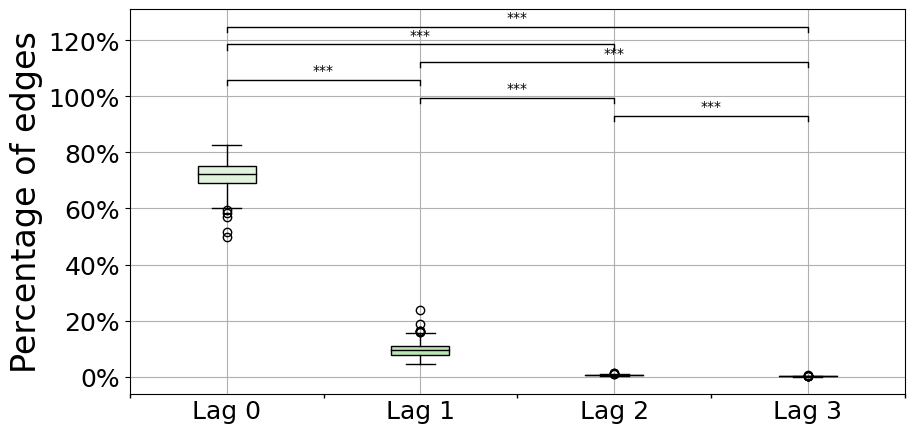

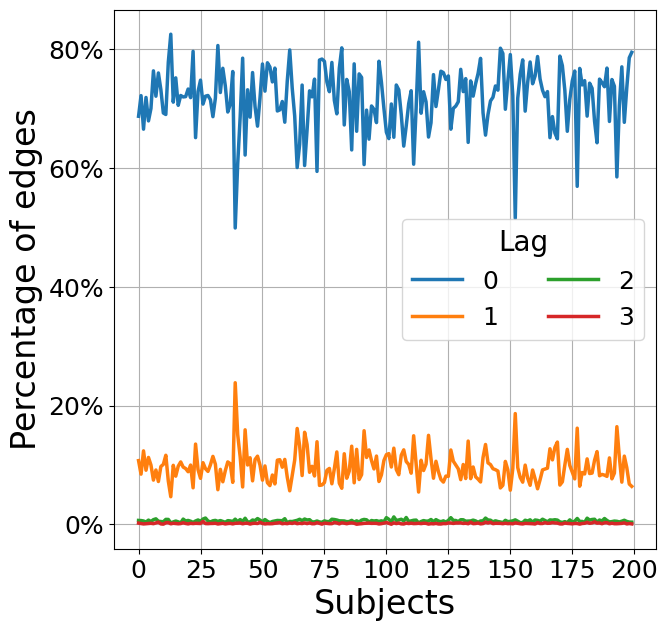

In [28]:
lag_labels = ['Lag 0','Lag 1','Lag 2', 'Lag 3']
plt.figure(figsize = (10,5))

ax = plt.subplot()
plt.yticks(fontsize = 18)
plt.grid()
plt.ylabel('Percentage of edges',fontsize = 24)

bp = ax.boxplot(density_all_lags, widths=0.3, patch_artist=True)

xticklabels = lag_labels
ax.set_xticklabels(xticklabels, fontsize = 18)
ax.tick_params(axis='x', which='major', length=0)
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='x', which='minor', length=3, width=1)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('Greens')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

plt.figure(figsize = (7,7))
p = plt.plot(np.array(density_each_lag_only).T, label= [0,1,2,3], linewidth = 2.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.grid()
plt.ylabel('Percentage of edges', fontsize = 24)
plt.xlabel('Subjects', fontsize = 24)
plt.xticks(fontsize = 18 )
plt.yticks(fontsize = 18 )
plt.legend(fontsize = 18, ncol = 2, title = 'Lag', title_fontsize = 20, loc = 'best')

### Are Similar Parcels Spatially Close to Each Other?

In [29]:
degree_all_subject_left_cortical = np.array(degree_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),:].flatten()
degree_all_subject_right_cortical = np.array(degree_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels,:].flatten()

degree_all_subject_left_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels+8:,:].flatten()
degree_all_subject_right_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels:num_cortical_parcels+8,:].flatten()

degree_all_subject_left = np.concatenate((degree_all_subject_left_cortical,degree_all_subject_left_subcortical ))
degree_all_subject_right = np.concatenate((degree_all_subject_right_cortical,degree_all_subject_right_subcortical ))

# left and right separated for female and male
degree_all_subject_left_female_cortical = np.array(degree_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),female_idx].flatten()
degree_all_subject_left_male_cortical = np.array(degree_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),male_idx].flatten()

degree_all_subject_left_female_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels+8:,female_idx].flatten()
degree_all_subject_left_male_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels+8:, male_idx].flatten()

degree_all_subject_left_female = np.concatenate((degree_all_subject_left_female_cortical,degree_all_subject_left_female_subcortical))
degree_all_subject_left_male = np.concatenate((degree_all_subject_left_male_cortical,degree_all_subject_left_male_subcortical))

degree_all_subject_right_female_cortical = np.array(degree_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels, female_idx].flatten()
degree_all_subject_right_male_cortical = np.array(degree_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels, male_idx].flatten()

degree_all_subject_right_female_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels+8:, female_idx].flatten()
degree_all_subject_right_male_subcortical = np.array(degree_all_parcels_individual_sub)[num_cortical_parcels+8:, male_idx].flatten()

degree_all_subject_right_female = np.concatenate((degree_all_subject_right_female_cortical,degree_all_subject_right_female_subcortical))
degree_all_subject_right_male = np.concatenate((degree_all_subject_right_male_cortical,degree_all_subject_right_male_subcortical))


In [30]:
causal_flow_all_subject_left_cortical = np.array(causal_flow_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),:].flatten()
causal_flow_all_subject_right_cortical = np.array(causal_flow_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels,:].flatten()

causal_flow_all_subject_left_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels+8:,:].flatten()
causal_flow_all_subject_right_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels:num_cortical_parcels+8,:].flatten()

causal_flow_all_subject_left = np.concatenate((causal_flow_all_subject_left_cortical,causal_flow_all_subject_left_subcortical ))
causal_flow_all_subject_right = np.concatenate((causal_flow_all_subject_right_cortical,causal_flow_all_subject_right_subcortical ))

# causal_flow and right separated for female and male

causal_flow_all_subject_left_female_cortical = np.array(causal_flow_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),female_idx].flatten()
causal_flow_all_subject_left_male_cortical = np.array(causal_flow_all_parcels_individual_sub)[0:int(num_cortical_parcels/2),male_idx].flatten()

causal_flow_all_subject_left_female_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels+8:,female_idx].flatten()
causal_flow_all_subject_left_male_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels+8:, male_idx].flatten()

causal_flow_all_subject_left_female = np.concatenate((causal_flow_all_subject_left_female_cortical,causal_flow_all_subject_left_female_subcortical))
causal_flow_all_subject_left_male = np.concatenate((causal_flow_all_subject_left_male_cortical,causal_flow_all_subject_left_male_subcortical))


causal_flow_all_subject_right_female_cortical = np.array(causal_flow_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels, female_idx].flatten()
causal_flow_all_subject_right_male_cortical = np.array(causal_flow_all_parcels_individual_sub)[int(num_cortical_parcels/2):num_cortical_parcels, male_idx].flatten()

causal_flow_all_subject_right_female_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels+8:, female_idx].flatten()
causal_flow_all_subject_right_male_subcortical = np.array(causal_flow_all_parcels_individual_sub)[num_cortical_parcels+8:, male_idx].flatten()

causal_flow_all_subject_right_female = np.concatenate((causal_flow_all_subject_right_female_cortical,causal_flow_all_subject_right_female_subcortical))
causal_flow_all_subject_right_male = np.concatenate((causal_flow_all_subject_right_male_cortical,causal_flow_all_subject_right_male_subcortical))

### Degree Laterality in Each Subnetwork

/tmp/ipykernel_2936789/823906907.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])


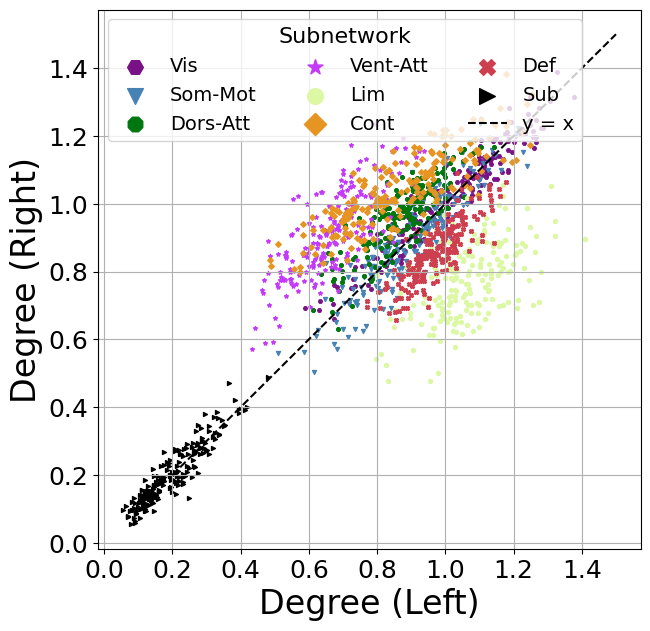

In [31]:
plt.figure(figsize = (7,7))

markers = ['H', 'v','8', '*', 'o', 'D','X','>']
standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for n in range(0, int((num_networks)/2)):

    label_left = net_labels[n]
    label_right = net_labels[n+8]

    label_short = net_labels_visualization[n][2:]

    left_idx = network_parcel_idx[label_left]
    right_idx = network_parcel_idx[label_right]
    
    x = np.mean(degree_all_parcels_individual_sub[left_idx,:], axis = 0).flatten()
    y = np.mean(degree_all_parcels_individual_sub[right_idx,:], axis = 0).flatten()

    plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])

    plt.grid(visible = True)
    plt.xlabel('Degree (Left)', fontsize = 24)
    plt.ylabel('Degree (Right)', fontsize = 24)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

xmin_degree, xmax_degree, ymin_degree, ymax_degree = plt.axis()

plt.plot(np.linspace(0.2, 1.5, num=50), np.linspace(0.2, 1.5, num=50), 'k--', label = 'y = x')

plt.legend(fontsize = 14, ncol = 3, title = 'Subnetwork', title_fontsize = 16, loc = 'best', markerscale = 4)


/tmp/ipykernel_2936789/4141676815.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])


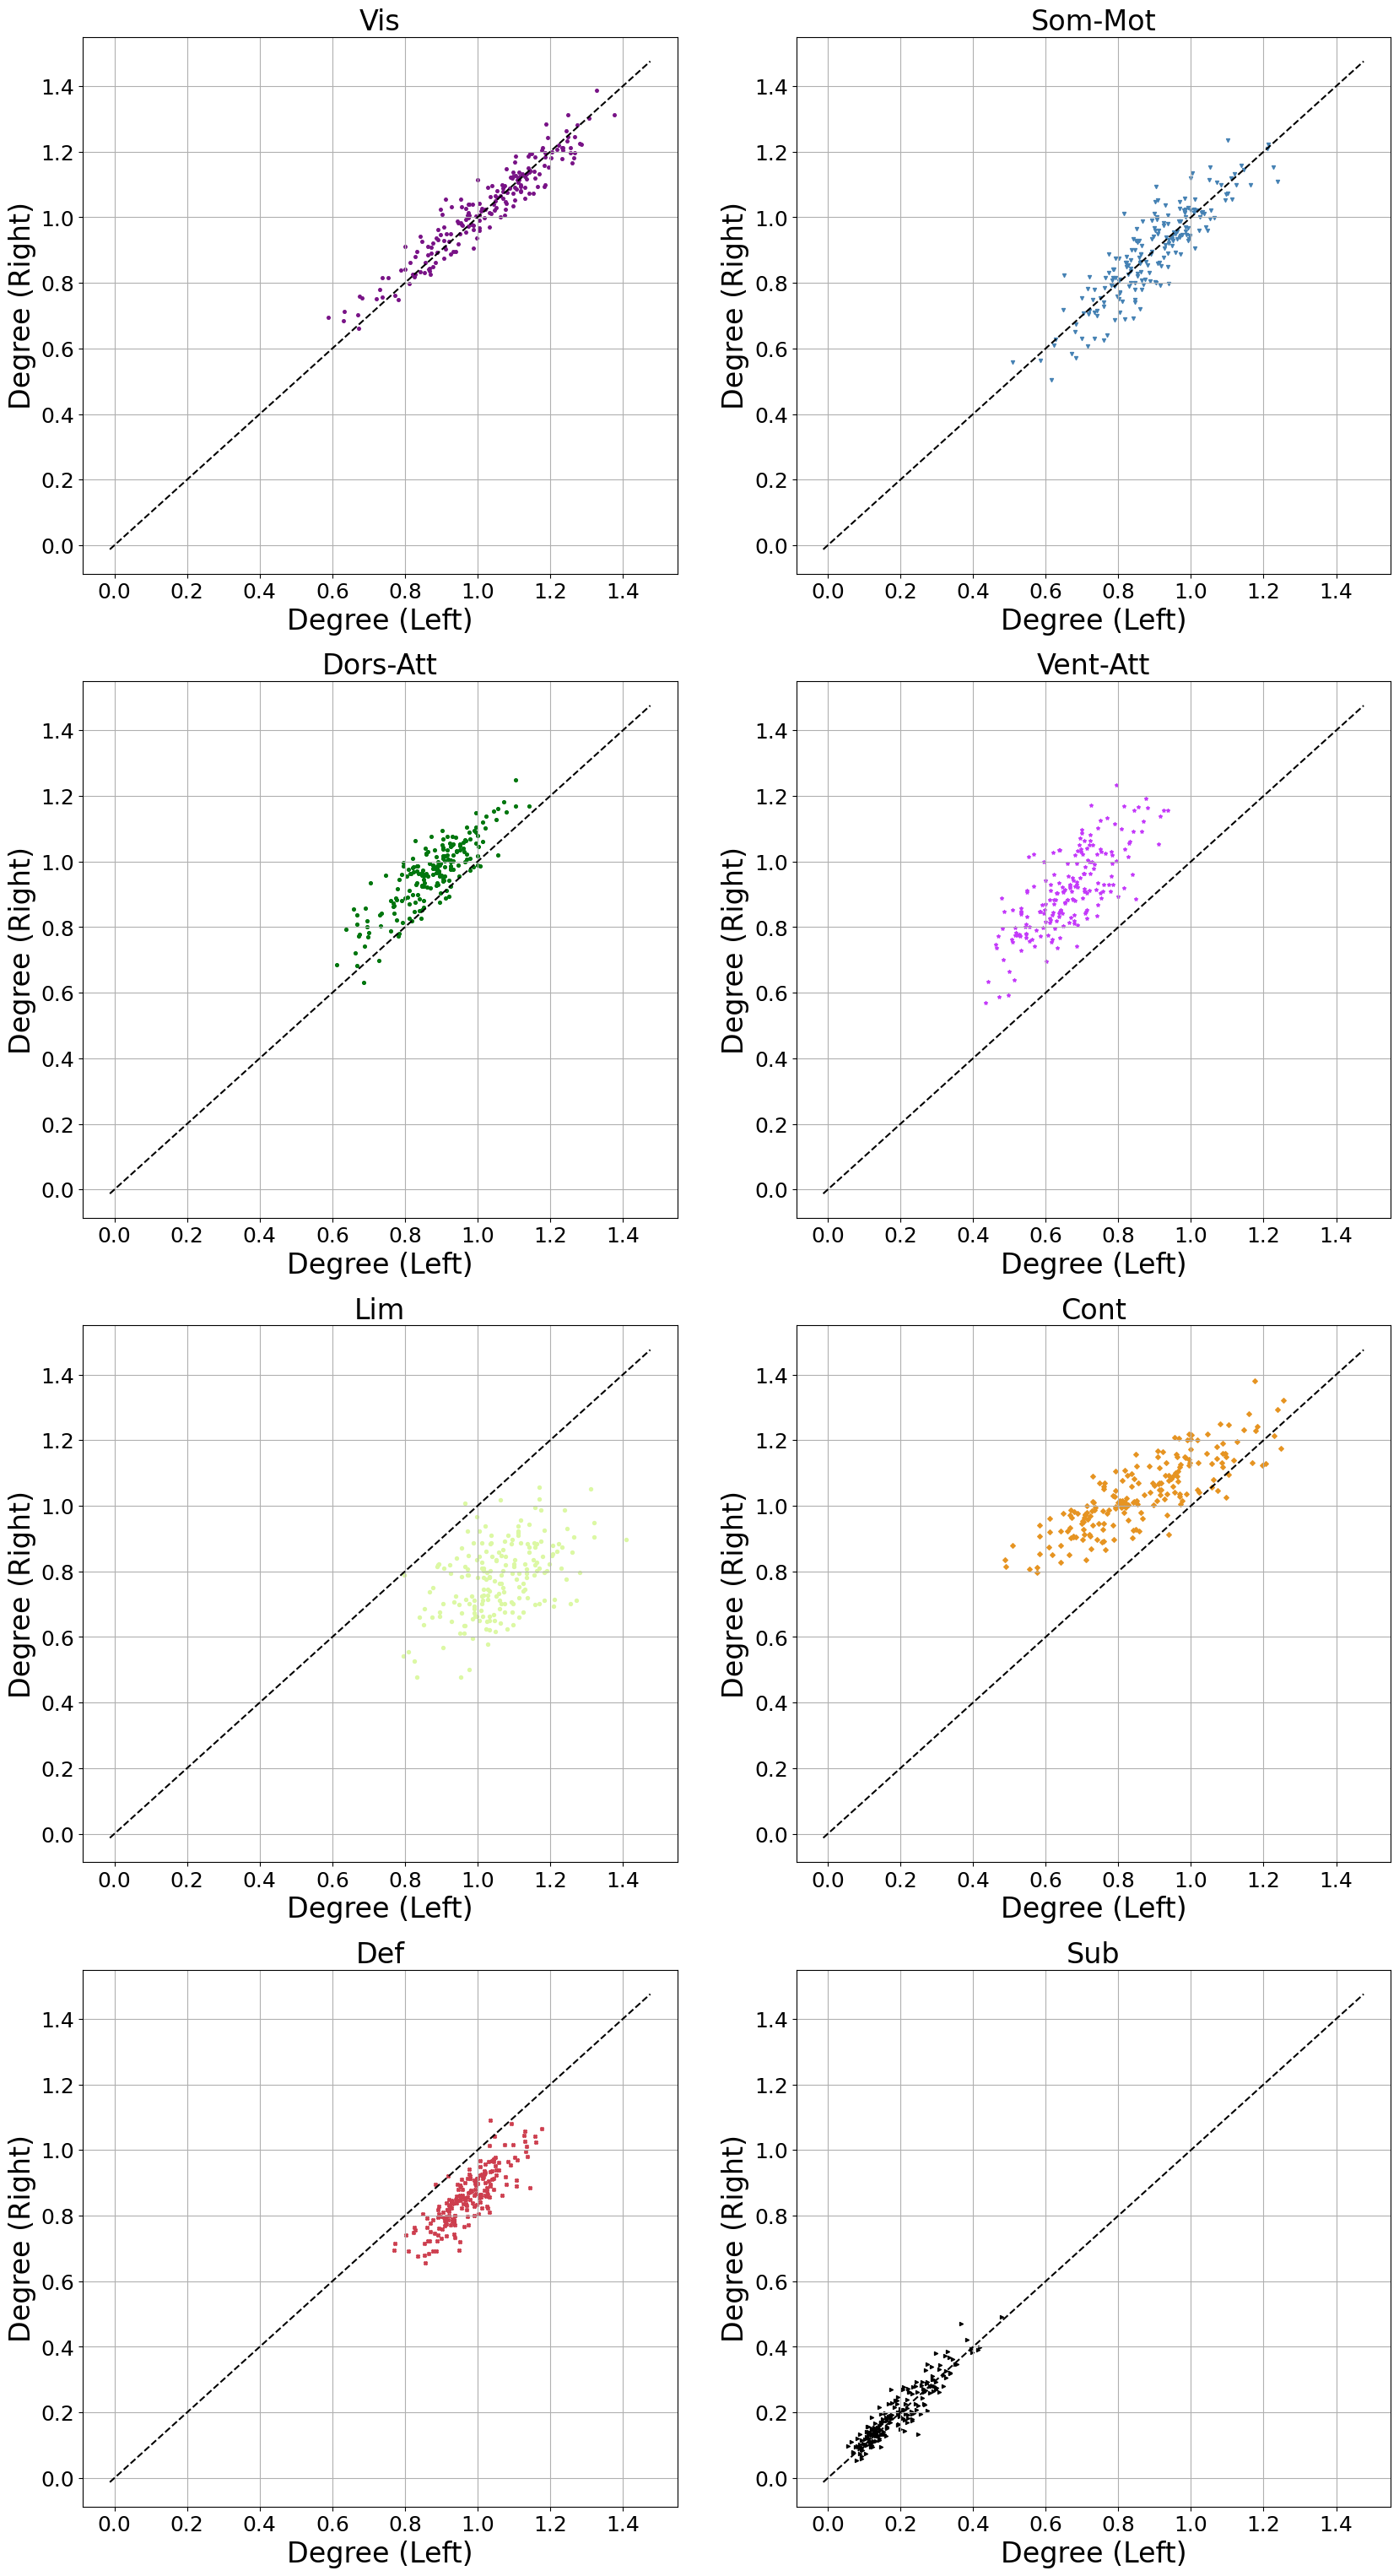

In [32]:
plt.figure(figsize = (20,38))

markers = ['H', 'v','8', '*', 'o', 'D','X','>']
standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for n in range(0, int((num_networks)/2)):

    label_left = net_labels[n]
    label_right = net_labels[n+8]

    label_short = net_labels_visualization[n][2:]

    left_idx = network_parcel_idx[label_left]
    right_idx = network_parcel_idx[label_right]
    
    x = np.mean(degree_all_parcels_individual_sub[left_idx,:], axis = 0).flatten()
    y = np.mean(degree_all_parcels_individual_sub[right_idx,:], axis = 0).flatten()

    plt.subplot(4,2,n+1)
    plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])

    plt.grid(visible = True)
    plt.xlabel('Degree (Left)', fontsize = 24)
    plt.ylabel('Degree (Right)', fontsize = 24)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title(label_short, fontsize = 24)

    plt.plot(np.linspace(np.min([xmin_degree,ymin_degree]), np.max([xmax_degree,ymax_degree]), num=50), np.linspace(np.min([xmin_degree,ymin_degree]), np.max([xmax_degree,ymax_degree]), num=50), 'k--', label = 'y = x')


### Causal Flow Laterality in Each Subnetwork

/tmp/ipykernel_2936789/4054833095.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])


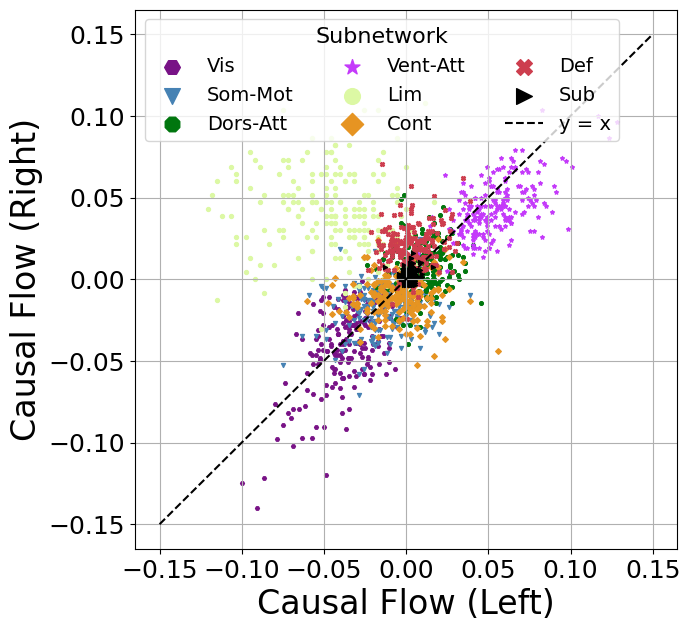

In [33]:
plt.figure(figsize = (7,7))

markers = ['H', 'v','8', '*', 'o', 'D','X','>']
standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for n in range(0, int((num_networks)/2)):

    label_left = net_labels[n]
    label_right = net_labels[n+8]

    label_short = net_labels_visualization[n][2:]

    left_idx = network_parcel_idx[label_left]
    right_idx = network_parcel_idx[label_right]
    
    x = np.mean(causal_flow_all_parcels_individual_sub[left_idx,:], axis = 0).flatten()
    y = np.mean(causal_flow_all_parcels_individual_sub[right_idx,:], axis = 0).flatten()

    plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])

    plt.grid(visible = True)
    plt.xlabel('Causal Flow (Left)', fontsize = 24)
    plt.ylabel('Causal Flow (Right)', fontsize = 24)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

xmin_causal_flow, xmax_causal_flow, ymin_causal_flow, ymax_causal_flow = plt.axis()

plt.plot(np.linspace(-0.15, 0.15, num=50), np.linspace(-0.15, 0.15, num=50), 'k--', label = 'y = x')
plt.legend(fontsize = 14, ncol = 3, title = 'Subnetwork', title_fontsize = 16, loc = 'best', markerscale = 4)


/tmp/ipykernel_2936789/757479515.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])


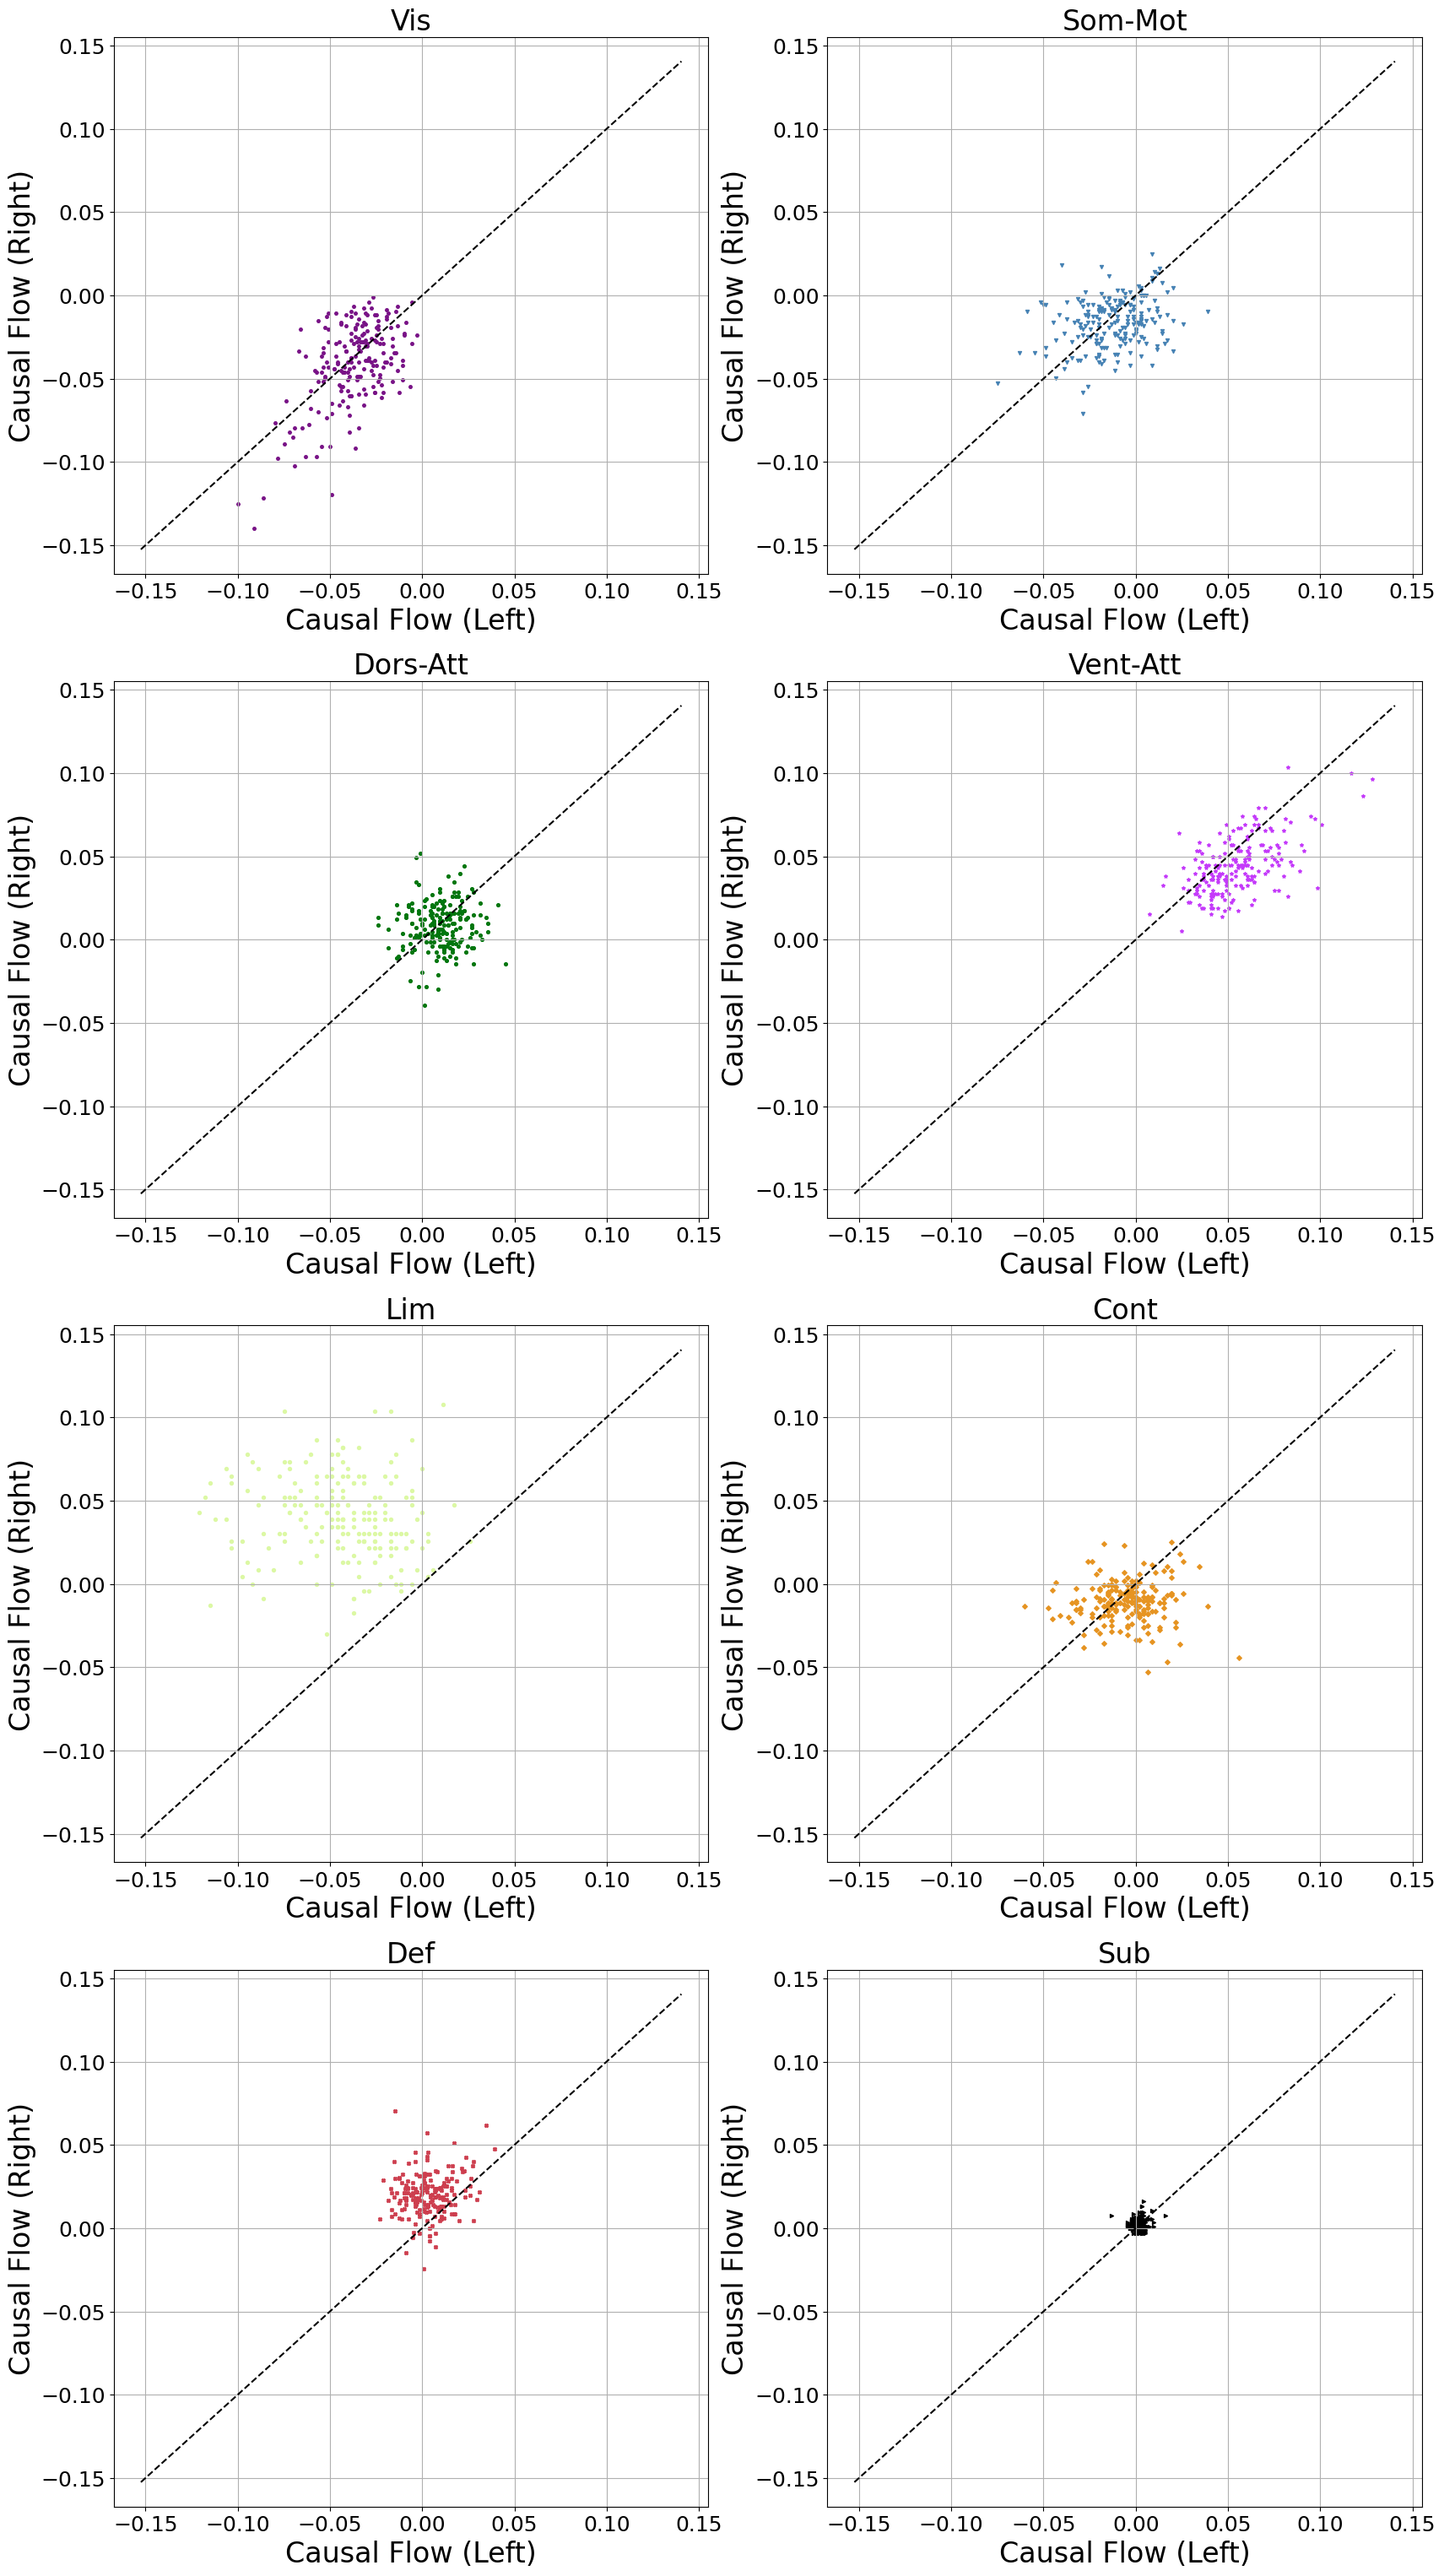

In [34]:
plt.figure(figsize = (20,38))

markers = ['H', 'v','8', '*', 'o', 'D','X','>']
standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for n in range(0, int((num_networks)/2)):

    label_left = net_labels[n]
    label_right = net_labels[n+8]

    label_short = net_labels_visualization[n][2:]

    left_idx = network_parcel_idx[label_left]
    right_idx = network_parcel_idx[label_right]
    
    x = np.mean(causal_flow_all_parcels_individual_sub[left_idx,:], axis = 0).flatten()
    y = np.mean(causal_flow_all_parcels_individual_sub[right_idx,:], axis = 0).flatten()

    plt.subplot(4,2,n+1)
    plt.scatter(x,y, label = label_short, s = 8, marker = markers[n], c = standard_colors[n,:])

    plt.grid(visible = True)
    plt.xlabel('Causal Flow (Left)', fontsize = 24)
    plt.ylabel('Causal Flow (Right)', fontsize = 24)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title(label_short, fontsize = 24)

    plt.plot(np.linspace(np.min([xmin_causal_flow,ymin_causal_flow]), np.max([xmax_causal_flow,ymax_causal_flow]), num=50), np.linspace(np.min([xmin_causal_flow,ymin_causal_flow]), np.max([xmax_causal_flow,ymax_causal_flow]), num=50), 'k--', label = 'y = x')


#### Distributions

14.614915187870634 1.1281760248837327e-48
0.7270838760287606 0.23358728775647697
Effect Sizes: 0.07317785337391691 0.021878122918495366


Text(0.2, 0.38, '-----ns-----')

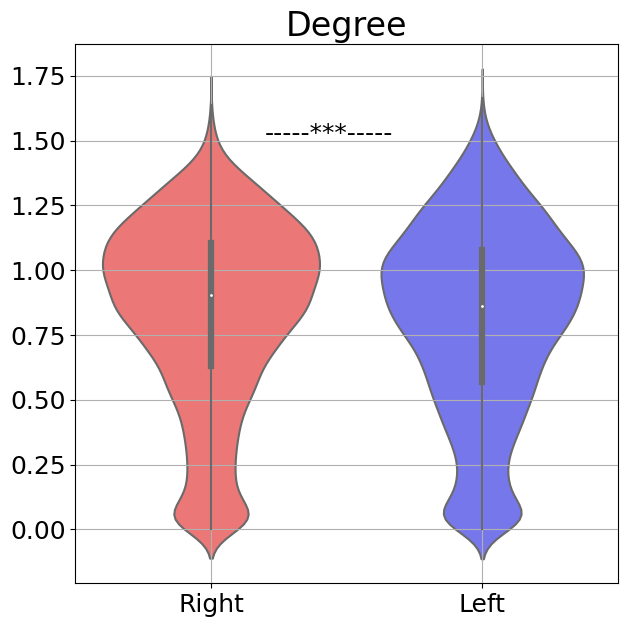

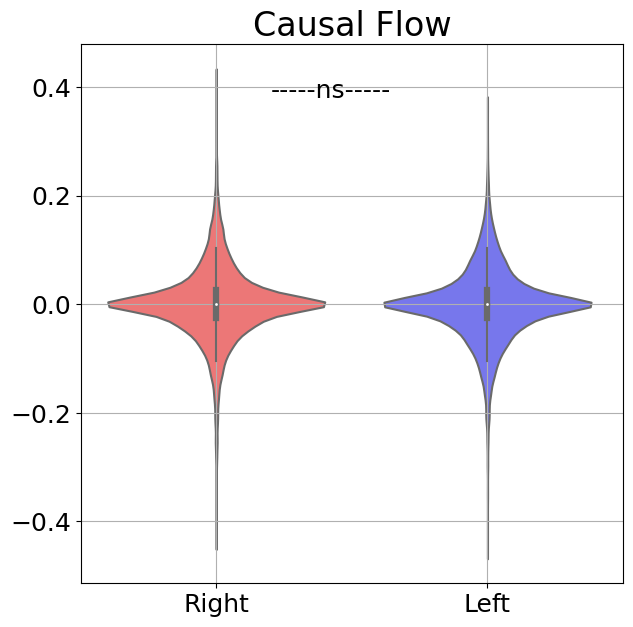

In [35]:
light_blue_rgb = (100/255, 100/255, 255/255)
light_red_rgb = (255/255, 100/255, 100/255) 

plt.figure(figsize = (7,7))
violin_parts = sns.violinplot([degree_all_subject_right, degree_all_subject_left], showmedians = True, showextrema = True, palette=[light_red_rgb,light_blue_rgb] )
plt.grid()
plt.title('Degree', fontsize = 24)
plt.xticks(np.arange(0,2), labels = ['Right','Left'], rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)
test_degree = scipy.stats.wilcoxon(degree_all_subject_right, degree_all_subject_left, alternative='greater', method = 'approx')

degree_right_left_effect_size = funcs.compute_cohens_d(degree_all_subject_right.flatten(), degree_all_subject_left.flatten())

pvalue = '-----***-----'
y_position = 1.5
plt.text(x=0.2, y=y_position, s=pvalue, fontsize=18)

plt.figure(figsize = (7,7))
violin_parts = sns.violinplot([causal_flow_all_subject_right,causal_flow_all_subject_left], showmedians = True, showextrema = True, palette=[light_red_rgb,light_blue_rgb])
plt.grid()
plt.title('Causal Flow', fontsize = 24)
plt.xticks(np.arange(0,2), labels = ['Right', 'Left'], rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)

test_causal_flow = scipy.stats.wilcoxon(causal_flow_all_subject_right, causal_flow_all_subject_left, alternative='greater',method = 'approx')
causal_flow_right_left_effect_size = funcs.compute_cohens_d(causal_flow_all_subject_right.flatten(), causal_flow_all_subject_left.flatten())

print(test_degree.zstatistic,test_degree.pvalue)
print(test_causal_flow.zstatistic,test_causal_flow.pvalue)

print('Effect Sizes:',degree_right_left_effect_size, causal_flow_right_left_effect_size)

pvalue = '-----ns-----'
y_position = 0.38
plt.text(x=0.2, y=y_position, s=pvalue, fontsize=18)


In [47]:
causal_flow_all_subject_left.flatten().shape

(11600,)

### Distribution of Edge Length and p-values in each lag (only each lag)

In [36]:
distances_all_lags = [0]* (tau_max+1)
pvaluess_all_lags = [0]* (tau_max+1)

for lag in range(0,tau_max+1):

    temp_distances = np.array([])
    temp_pvalues = np.array([])

    for s in range(0, num_subjects_ready):
            
        current_sub = each_lag_graph_all[lag][s]
        current_edge_p_value = time_series_graph_hcp_rest_all_subjects_pvalues[s][:,:, lag]
        current_edge_distance = parcel_distances

        sub_edges_pvalues =  current_edge_p_value[current_sub == 1]
        sub_edges_distances = current_edge_distance[current_sub == 1]
        
        # select significant long edges

        temp_distances = np.concatenate((temp_distances,sub_edges_distances))
        temp_pvalues = np.concatenate((temp_pvalues,sub_edges_pvalues))

    distances_all_lags[lag] = temp_distances
    pvaluess_all_lags[lag] = temp_pvalues


RanksumsResult(statistic=9.603184107551948, pvalue=3.875606354053255e-22) RanksumsResult(statistic=2.17371239879729, pvalue=0.014863370460252904) RanksumsResult(statistic=1.6013163939366715, pvalue=0.054653429890688145)


RanksumsResult(statistic=-300.9258960593639, pvalue=0.0) RanksumsResult(statistic=-55.31148226188964, pvalue=0.0) RanksumsResult(statistic=-7.102646195650661, pvalue=6.119522402889577e-13)


Text(2.2, 0.0002, '---***---')

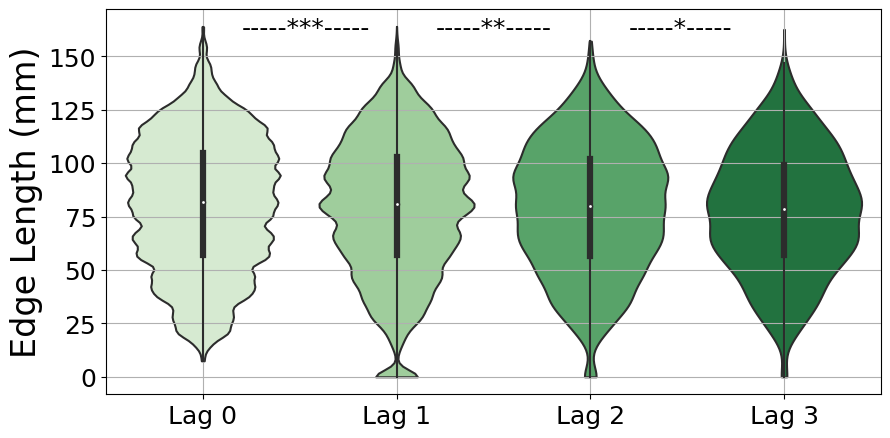

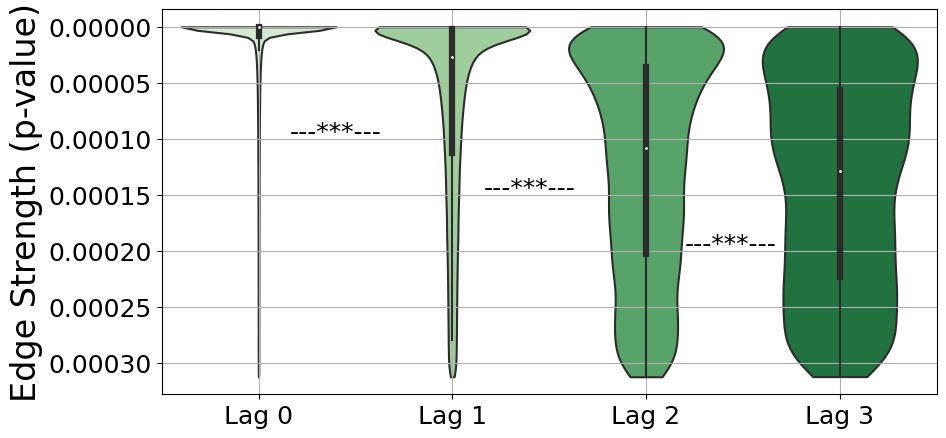

In [37]:
lag_labels = ['Lag 0','Lag 1','Lag 2', 'Lag 3']
plt.figure(figsize = (10,5))

violin_parts = sns.violinplot([np.array(distances_all_lags[0]), np.array(distances_all_lags[1]),np.array(distances_all_lags[2]),np.array(distances_all_lags[3])], scale='width', palette = 'Greens',  cut=0)
plt.xticks(np.arange(0,4), labels = lag_labels, rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)
plt.grid()
plt.ylabel('Edge Length (mm)', fontsize = 24)

lag0_1 = scipy.stats.ranksums(np.array(distances_all_lags[0]), np.array(distances_all_lags[1]), alternative='greater')
lag1_2 = scipy.stats.ranksums(np.array(distances_all_lags[1]), np.array(distances_all_lags[2]), alternative='greater')
lag2_3 = scipy.stats.ranksums(np.array(distances_all_lags[2]), np.array(distances_all_lags[3]), alternative='greater')

print(lag0_1, lag1_2,lag2_3 )

pvalue_01 = '-----***-----'
pvalue_12 = '-----**-----'
pvalue_23 = '-----*-----'

y_position = 160
plt.text(x=0.2, y=y_position, s=pvalue_01, fontsize=18)
plt.text(x=1.2, y=y_position, s=pvalue_12, fontsize=18)
plt.text(x=2.2, y=y_position, s=pvalue_23, fontsize=18)

plt.figure(figsize = (10,5))
ax = plt.subplot()
violin_parts = sns.violinplot([np.array(pvaluess_all_lags[0]), np.array(pvaluess_all_lags[1]),np.array(pvaluess_all_lags[2]),np.array(pvaluess_all_lags[3])], scale='width', palette= 'Greens', cut=0)
plt.xticks(np.arange(0,4), labels = lag_labels, rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)
plt.grid()
ax.invert_yaxis()
plt.ylabel('Edge Strength (p-value)', fontsize = 24)

lag0_1 = scipy.stats.ranksums(np.array(pvaluess_all_lags[0]), np.array(pvaluess_all_lags[1]), alternative='less')
lag1_2 = scipy.stats.ranksums(np.array(pvaluess_all_lags[1]), np.array(pvaluess_all_lags[2]), alternative='less')
lag2_3 = scipy.stats.ranksums(np.array(pvaluess_all_lags[2]), np.array(pvaluess_all_lags[3]), alternative='less')

print(lag0_1, lag1_2,lag2_3 )

pvalue_01 = '---***---'
pvalue_12 = '---***---'
pvalue_23 = '---***---'

y_position = 0.00032
plt.text(x=0.16, y=0.0001, s=pvalue_01, fontsize=18)
plt.text(x=1.16, y=0.00015, s=pvalue_12, fontsize=18)
plt.text(x=2.20, y=0.00020, s=pvalue_23, fontsize=18)


### Euclidean Distance Between Each Pair of Parcels

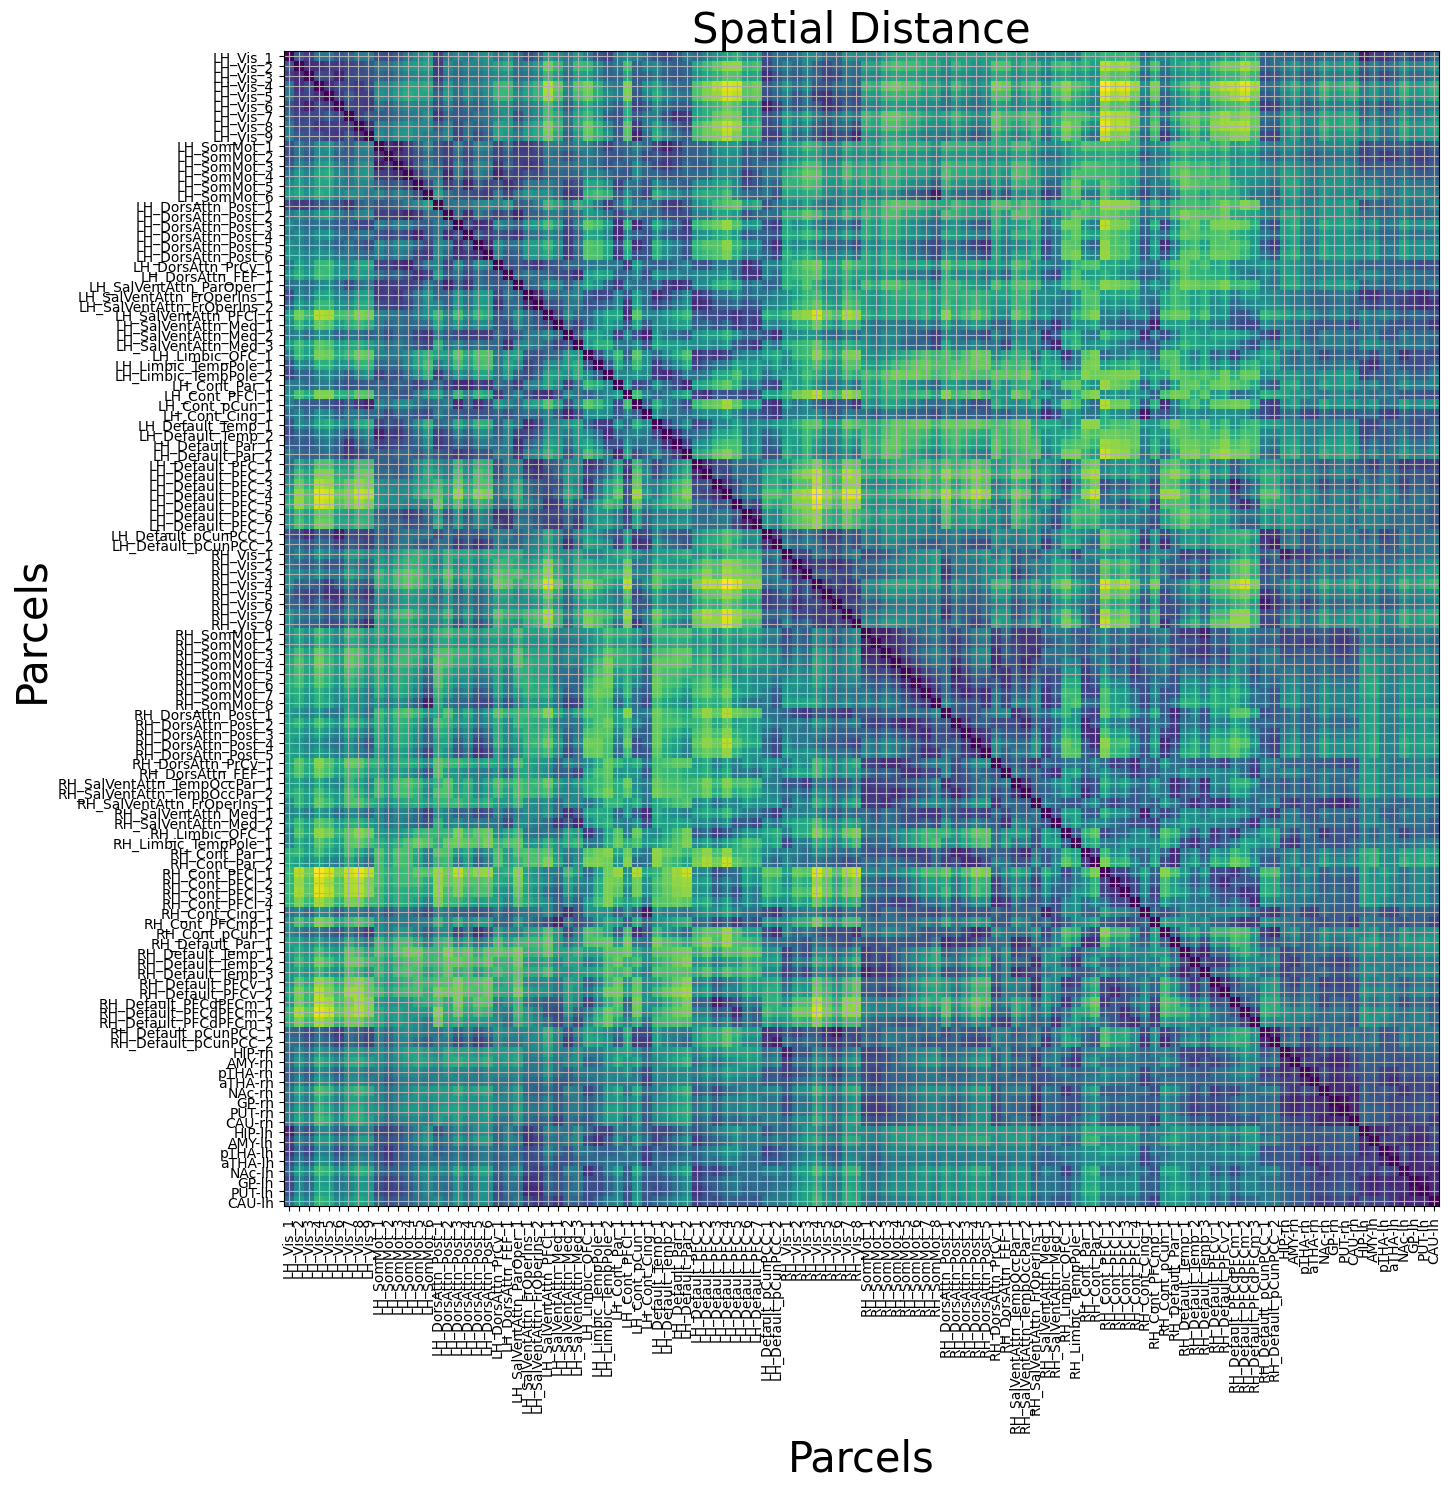

In [38]:
plt.figure(figsize = (15,15))
p = plt.imshow(parcel_distances)

plt.xlabel('Parcels', fontsize = 30)
plt.ylabel('Parcels', fontsize = 30)

plt.title('Spatial Distance', fontsize = 30)
plt.grid()

p = plt.xticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 90)
p = plt.yticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 0)


### Distribution of Causal Edge Length vs Distribution of Euclieadn Distances Between All Pairs of Parcels

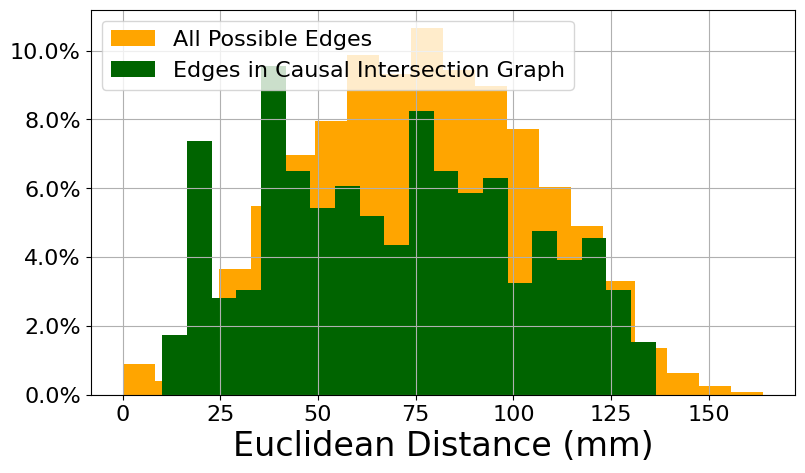

In [39]:
plt.figure(figsize = (20,5))

np.fill_diagonal(parcel_distances, 0)
plt.subplot(1,2,1)
plt.hist(parcel_distances.flatten(), 20, weights=np.ones(len(parcel_distances.flatten())) / len(parcel_distances.flatten()), label = 'All Possible Edges', color = 'orange')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Euclidean Distance (mm)', fontsize = 24)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)


avg_graph = np.mean(np.array(hcp_rest_all_graphs), axis = 0)
avg_graph_thresholded = np.zeros_like(avg_graph)
threhold  = 1
avg_graph_thresholded[avg_graph >= threhold] = 1
np.fill_diagonal(avg_graph_thresholded, 0)
avg_graph_thresholded_distance = parcel_distances[avg_graph_thresholded == 1]

plt.hist(avg_graph_thresholded_distance, 20, weights=np.ones(len(avg_graph_thresholded_distance)) / len(avg_graph_thresholded_distance), label = 'Edges in Causal Intersection Graph', color = 'darkgreen')

plt.legend(fontsize = 16, loc = 'upper left')


### Similarities Between Parcels

In [40]:
degree_similarities_between_parcels = np.corrcoef(degree_all_parcels_individual_sub)
causal_flow_similarities_between_parcels = np.corrcoef(causal_flow_all_parcels_individual_sub)

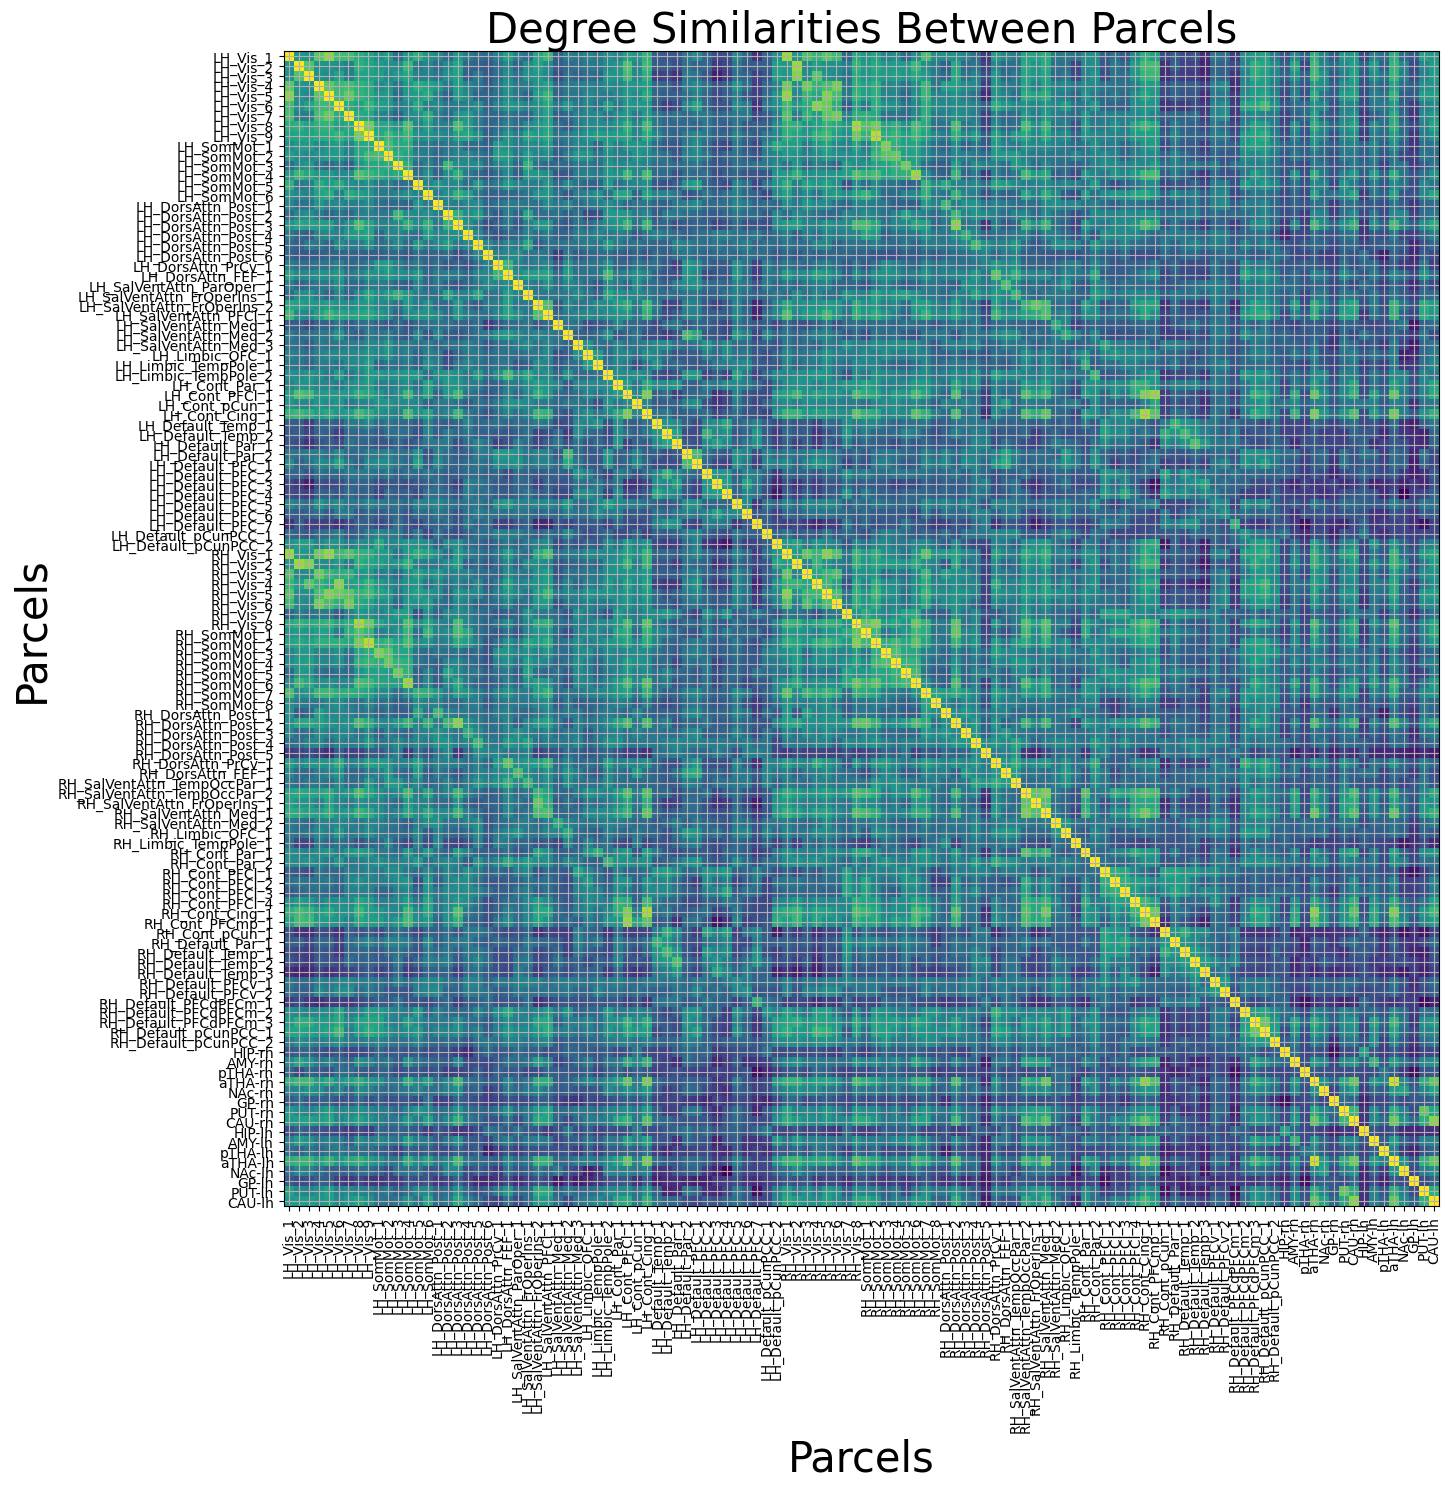

In [41]:
plt.figure(figsize = (15,15))
p = plt.imshow(degree_similarities_between_parcels)

plt.xlabel('Parcels', fontsize = 30)
plt.ylabel('Parcels', fontsize = 30)

plt.title('Degree Similarities Between Parcels', fontsize = 30)
plt.grid()

p = plt.xticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 90)
p = plt.yticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 0)


[[-0.00067407]] [0.37881092]
Correlations between degree similarities and parcels distances for:
Intra-hemispheric edges: PearsonRResult(statistic=-0.2651714495457755, pvalue=2.9243684339735346e-83) ConfidenceInterval(low=-0.29043458947795076, high=-0.2395389066509326)
Inter-hemispheric: PearsonRResult(statistic=-0.09027487591843755, pvalue=4.688241113880434e-06) ConfidenceInterval(low=-0.12853597148456852, high=-0.05174543081028813)
All parcels: PearsonRResult(statistic=-0.11956110121928483, pvalue=4.942417367582411e-44) ConfidenceInterval(low=-0.13618250677023974, high=-0.1028724037253561)


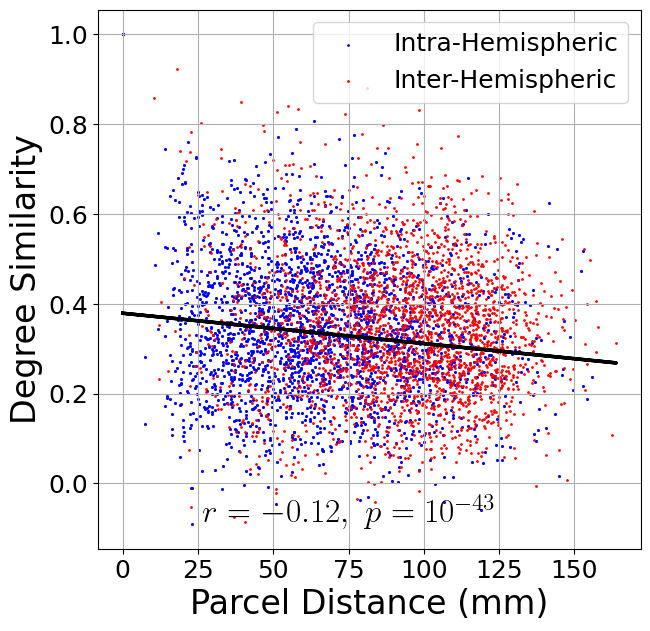

In [42]:
num_parcels_lh = int(num_cortical_parcels/2)
num_parcels_rh = int(num_cortical_parcels/2)

x_l_cor = np.reshape(parcel_distances[0:num_parcels_lh,0:num_parcels_lh], num_parcels_lh*num_parcels_lh)
x_r_cor = np.reshape(parcel_distances[num_parcels_lh:num_parcels_lh+num_parcels_rh,num_parcels_lh:num_parcels_lh+num_parcels_rh], num_parcels_rh*num_parcels_rh)
x_lr_cor = np.reshape(parcel_distances[num_parcels_lh:num_parcels_lh+num_parcels_rh,0:num_parcels_lh], num_parcels_rh*num_parcels_lh)

x_l_sub = np.reshape(parcel_distances[num_cortical_parcels+8:,num_cortical_parcels+8:], 8*8)
x_r_sub = np.reshape(parcel_distances[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels:num_cortical_parcels+8], 8*8)
x_lr_sub = np.reshape(parcel_distances[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels+8:], 8*8)


y_l_cor = np.reshape(degree_similarities_between_parcels[0:num_parcels_lh,0:num_parcels_lh], num_parcels_lh*num_parcels_lh)
y_r_cor = np.reshape(degree_similarities_between_parcels[num_parcels_lh:num_parcels_lh+num_parcels_rh,num_parcels_lh:num_parcels_lh+num_parcels_rh], num_parcels_rh*num_parcels_rh)
y_lr_cor = np.reshape(degree_similarities_between_parcels[num_parcels_lh:num_parcels_lh+num_parcels_rh,0:num_parcels_lh], num_parcels_rh*num_parcels_lh)

y_l_sub = np.reshape(degree_similarities_between_parcels[num_cortical_parcels+8:,num_cortical_parcels+8:], 8*8)
y_r_sub = np.reshape(degree_similarities_between_parcels[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels:num_cortical_parcels+8], 8*8)
y_lr_sub = np.reshape(degree_similarities_between_parcels[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels+8:], 8*8)

# concatenate cortical and subcortical

x_within = np.concatenate((x_l_cor,x_r_cor,x_l_sub,x_r_sub ))
y_within = np.concatenate((y_l_cor,y_r_cor,y_l_sub,y_r_sub ))

x_between = np.concatenate((x_lr_cor,x_lr_sub ))
y_between = np.concatenate((y_lr_cor,y_lr_sub ))

plt.figure(figsize = (7,7))
plt.scatter(x_within,y_within, color = 'blue', label = 'Intra-Hemispheric', marker = 'o', s = 1)
plt.scatter(x_between,y_between, color = 'red', label = 'Inter-Hemispheric', marker = 'o', s = 1)


from sklearn.linear_model import LinearRegression

y = degree_similarities_between_parcels.flatten().reshape(-1, 1)
x = parcel_distances.flatten().reshape(-1, 1)

reg = LinearRegression().fit(x, y)
print(reg.coef_, reg.intercept_)

y_pred = reg.predict(x)

plt.plot(x, y_pred, '-', color = 'black', linewidth = 2.5)
plt.grid()
plt.legend(fontsize = 18)
plt.xlabel('Parcel Distance (mm)', fontsize = 24)
plt.ylabel('Degree Similarity', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.rc('text', usetex=True)
plt.text(75, -0.1, r"$r = -0.12,~ p = 10^{-43}$", ha='center', va='bottom', fontsize=24, color='black')
plt.rc('text', usetex=False)

within_corr = scipy.stats.pearsonr(x_within,y_within)
between_corr = scipy.stats.pearsonr(x_between,y_between)

corr_degree_distance_all = scipy.stats.pearsonr(degree_similarities_between_parcels.flatten(),parcel_distances.flatten())

print('Correlations between degree similarities and parcels distances for:')
print('Intra-hemispheric edges:',within_corr, within_corr.confidence_interval(confidence_level = 0.95))
print('Inter-hemispheric:',between_corr, between_corr.confidence_interval(confidence_level = 0.95) )
print('All parcels:', corr_degree_distance_all, corr_degree_distance_all.confidence_interval(confidence_level = 0.95))

### Edge Strength vs Parcel DIstance

In [43]:
def movingaverage(x,y, window_size, step):

    x_begin = 0
    x_max = np.max(x)

    x_out = []
    y_out = []

    while (x_begin+window_size) <= x_max:
        
        x_idx = np.where(np.logical_and(x<(x_begin+window_size), x>=(x_begin)))
        x_mean = np.mean(x[x_idx])
        y_mean = np.mean(y[x_idx])
        
        x_out.append(x_mean)
        y_out.append(y_mean)

        x_begin = x_begin + step
            
    return np.array(x_out), np.array(y_out)

Within Correlations: PearsonRResult(statistic=0.09278004057191741, pvalue=3.931524736391956e-06) ConfidenceInterval(low=0.053503888269356585, high=0.13176956653734936)
Between Correlations: PearsonRResult(statistic=0.06986724950562688, pvalue=0.011743627140333862) ConfidenceInterval(low=0.015557560622729354, high=0.12376589846449601)


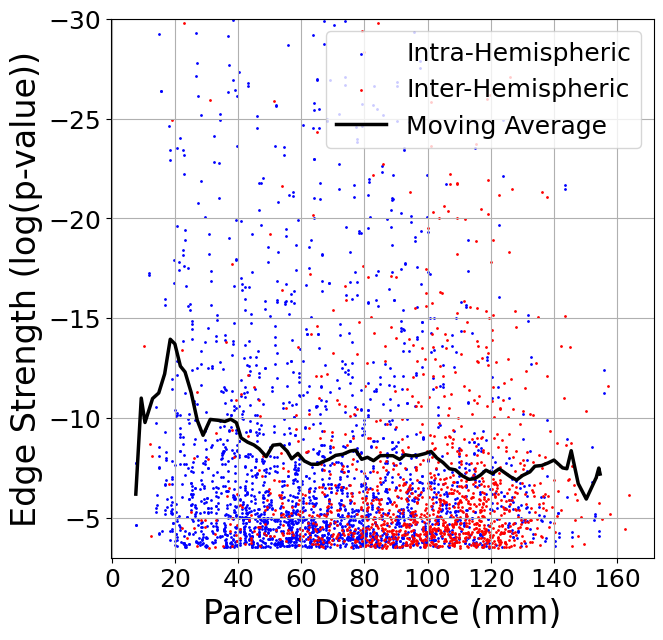

In [44]:
num_parcels_lh = int(num_cortical_parcels/2)
num_parcels_rh = int(num_cortical_parcels/2)

x_l_cor = np.reshape(parcel_distances[0:num_parcels_lh,0:num_parcels_lh], num_parcels_lh*num_parcels_lh)
x_r_cor = np.reshape(parcel_distances[num_parcels_lh:num_parcels_lh+num_parcels_rh,num_parcels_lh:num_parcels_lh+num_parcels_rh], num_parcels_rh*num_parcels_rh)
x_lr_cor = np.reshape(parcel_distances[num_parcels_lh:num_parcels_lh+num_parcels_rh,0:num_parcels_lh], num_parcels_rh*num_parcels_lh)

x_l_sub = np.reshape(parcel_distances[num_cortical_parcels+8:,num_cortical_parcels+8:], 8*8)
x_r_sub = np.reshape(parcel_distances[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels:num_cortical_parcels+8], 8*8)
x_lr_sub = np.reshape(parcel_distances[num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels+8:], 8*8)


y_l_cor = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,0:num_parcels_lh,0:num_parcels_lh], axis = 0), num_parcels_lh*num_parcels_lh)
y_r_cor = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,num_parcels_lh:num_parcels_lh+num_parcels_rh,num_parcels_lh:num_parcels_lh+num_parcels_rh], axis = 0), num_parcels_rh*num_parcels_rh)
y_lr_cor = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,num_parcels_lh:num_parcels_lh+num_parcels_rh,0:num_parcels_lh], axis = 0), num_parcels_rh*num_parcels_lh)

y_l_sub = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,num_cortical_parcels+8:,num_cortical_parcels+8:], axis = 0), 8*8)
y_r_sub = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels:num_cortical_parcels+8], axis = 0), 8*8)
y_lr_sub = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values)[:,num_cortical_parcels:num_cortical_parcels+8,num_cortical_parcels+8:], axis = 0), 8*8)

# concatenate cortical and subcortical

x_within = np.concatenate((x_l_cor,x_r_cor,x_l_sub,x_r_sub ))
y_within = np.concatenate((y_l_cor,y_r_cor,y_l_sub,y_r_sub ))

x_between = np.concatenate((x_lr_cor,x_lr_sub ))
y_between = np.concatenate((y_lr_cor,y_lr_sub ))

x_within = x_within[y_within>0]
y_within = y_within[y_within>0]

x_between = x_between[y_between >0]
y_between = y_between[y_between>0]

y_within = y_within[x_within>0]
x_within = x_within[x_within >0]

y_between = y_between[x_between >0]
x_between = x_between[x_between>0]


x_within = x_within[y_within <= alpha_level]
y_within = y_within[y_within <= alpha_level]

x_between = x_between[y_between <= alpha_level]
y_between = y_between[y_between <= alpha_level]

y_within = np.log10(y_within)
y_between = np.log10(y_between)

plt.figure(figsize = (7,7))
ax = plt.subplot()
plt.scatter(x_within,y_within, color = 'blue', label = 'Intra-Hemispheric', marker = 'o', s = 1)
plt.scatter(x_between,y_between, color = 'red', label = 'Inter-Hemispheric', marker = 'o', s = 1)


plt.grid()
plt.legend(fontsize = 18)
plt.xlabel('Parcel Distance (mm)', fontsize = 24)
plt.ylabel('Edge Strength (p-value)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

within_corr = scipy.stats.pearsonr(x_within,y_within)
between_corr = scipy.stats.pearsonr(x_between,y_between)


####
x = np.reshape(parcel_distances, num_parcels*num_parcels)
y = np.reshape(np.median(np.array(hcp_rest_all_graphs_p_values), axis = 0), num_parcels*num_parcels)

x = x[y>0]
y = y[y>0]

x = x[y <= alpha_level]
y = y[y <= alpha_level]

y = y[x>0]
x = x[x>0]

y = np.log10(y)

## find a moving average/ median

window_size = 10
step = 2

sort = np.argsort(x)

y = y[sort]
x = x[sort]

x_m,y_m = movingaverage(x,y, window_size, step)

plt.plot(x_m,y_m, '-', color = 'black', linewidth = 2.5, label = 'Moving Average')
plt.legend(fontsize = 18)
plt.xlabel('Parcel Distance (mm)', fontsize = 24)
plt.ylabel('Edge Strength (log(p-value))', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim([-30, -3])
ax.invert_yaxis()

print('Within Correlations:',within_corr, within_corr.confidence_interval(confidence_level = 0.95))
print('Between Correlations:', between_corr,between_corr.confidence_interval(confidence_level = 0.95))


# Compare Functional Connectivity and Causal Graphs

#### Average Graph (among subjects)

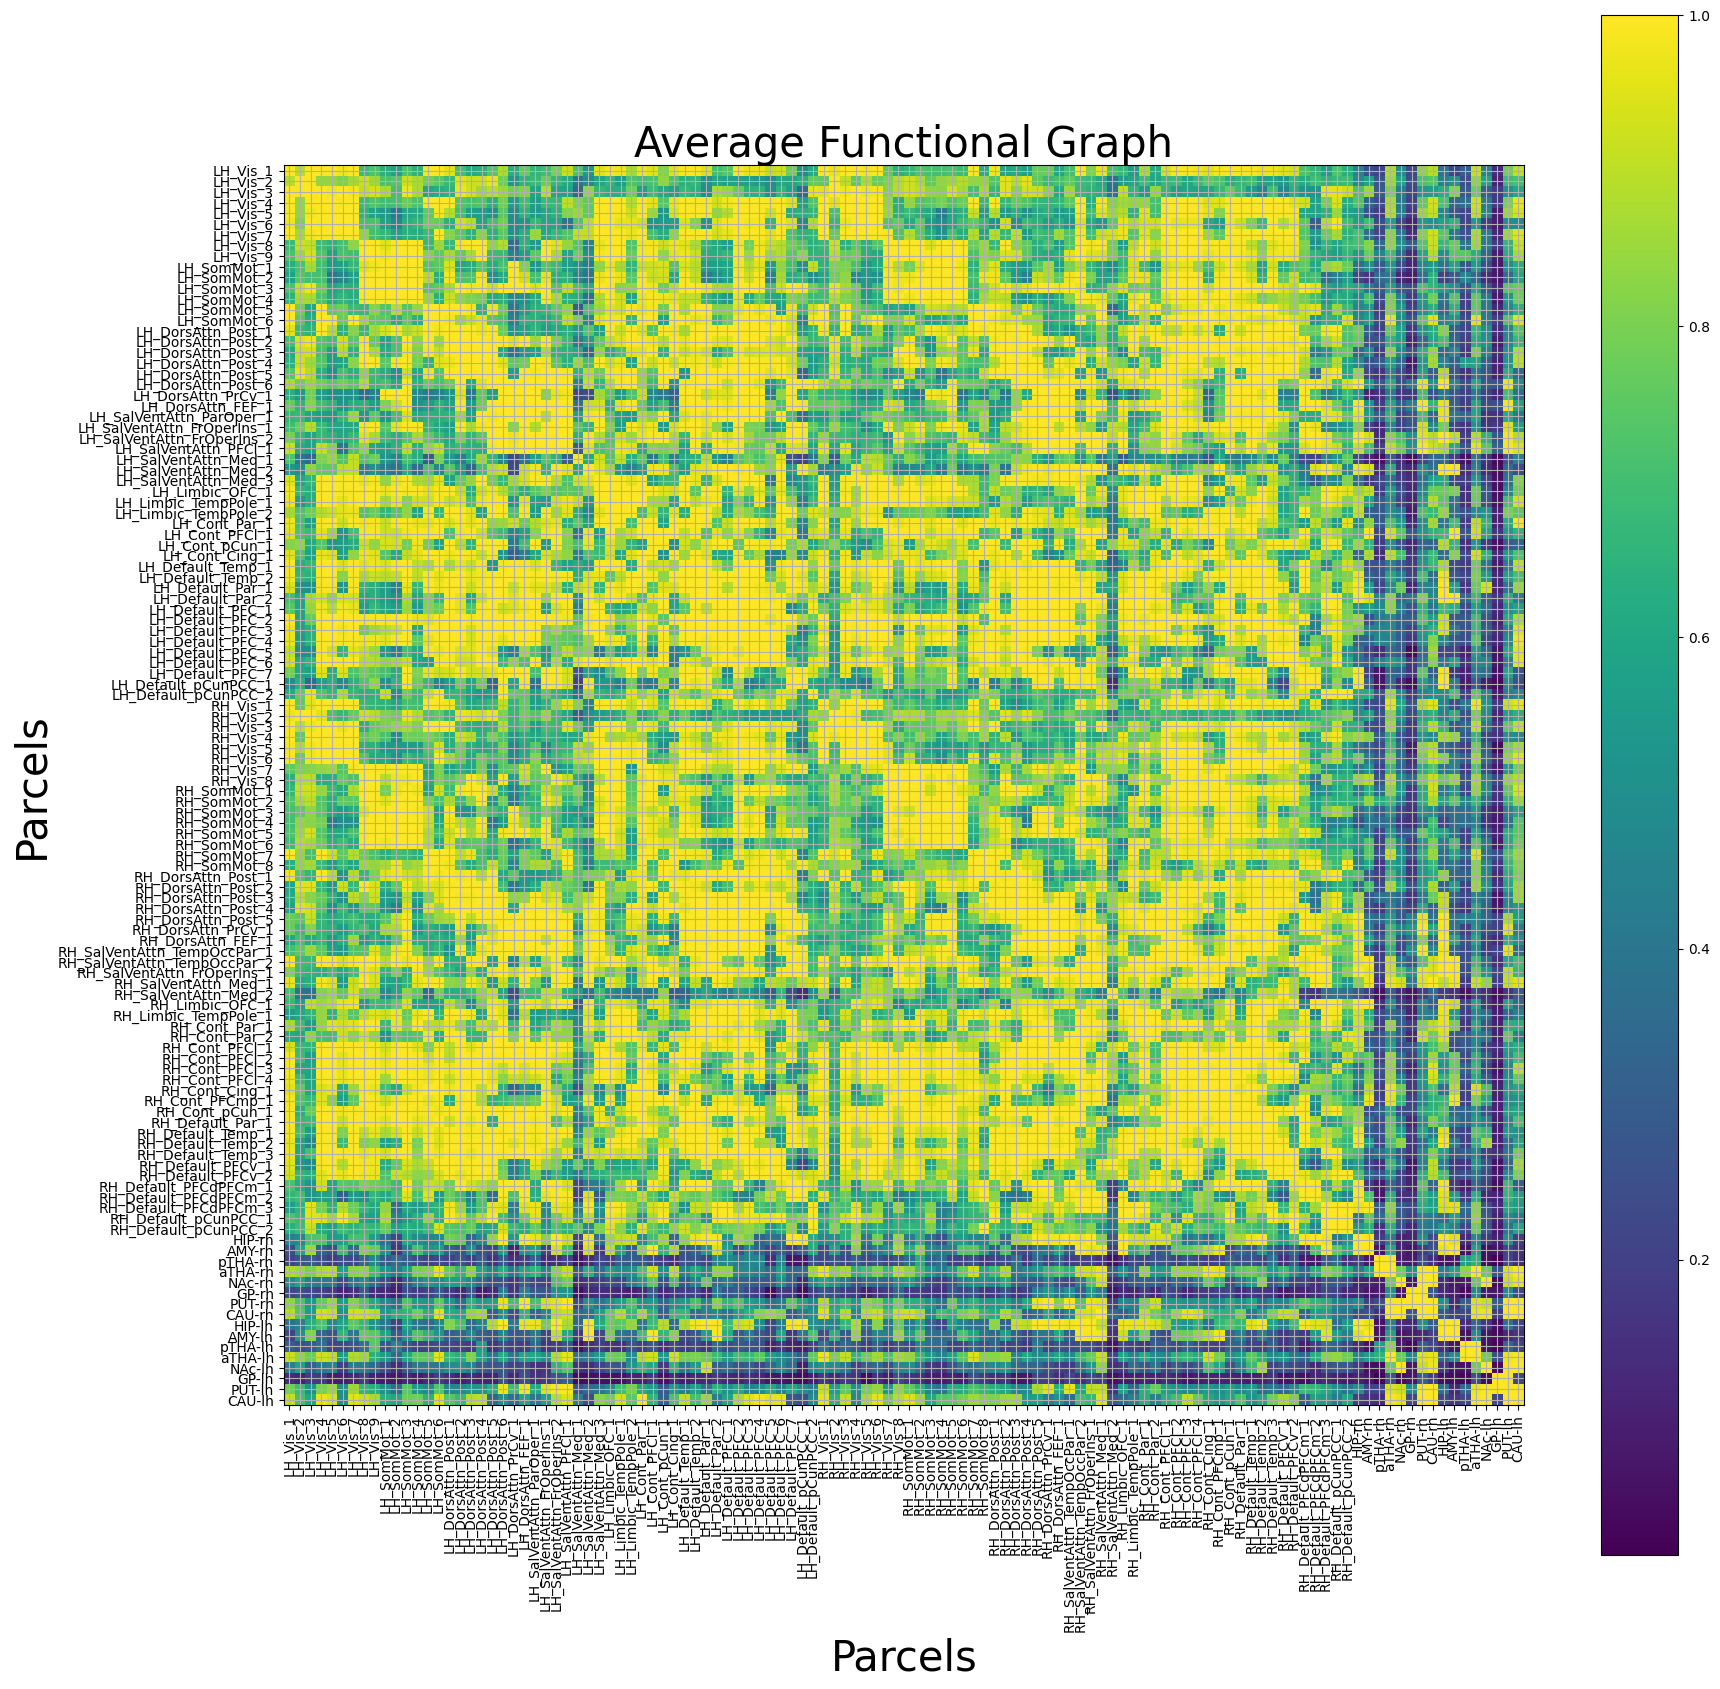

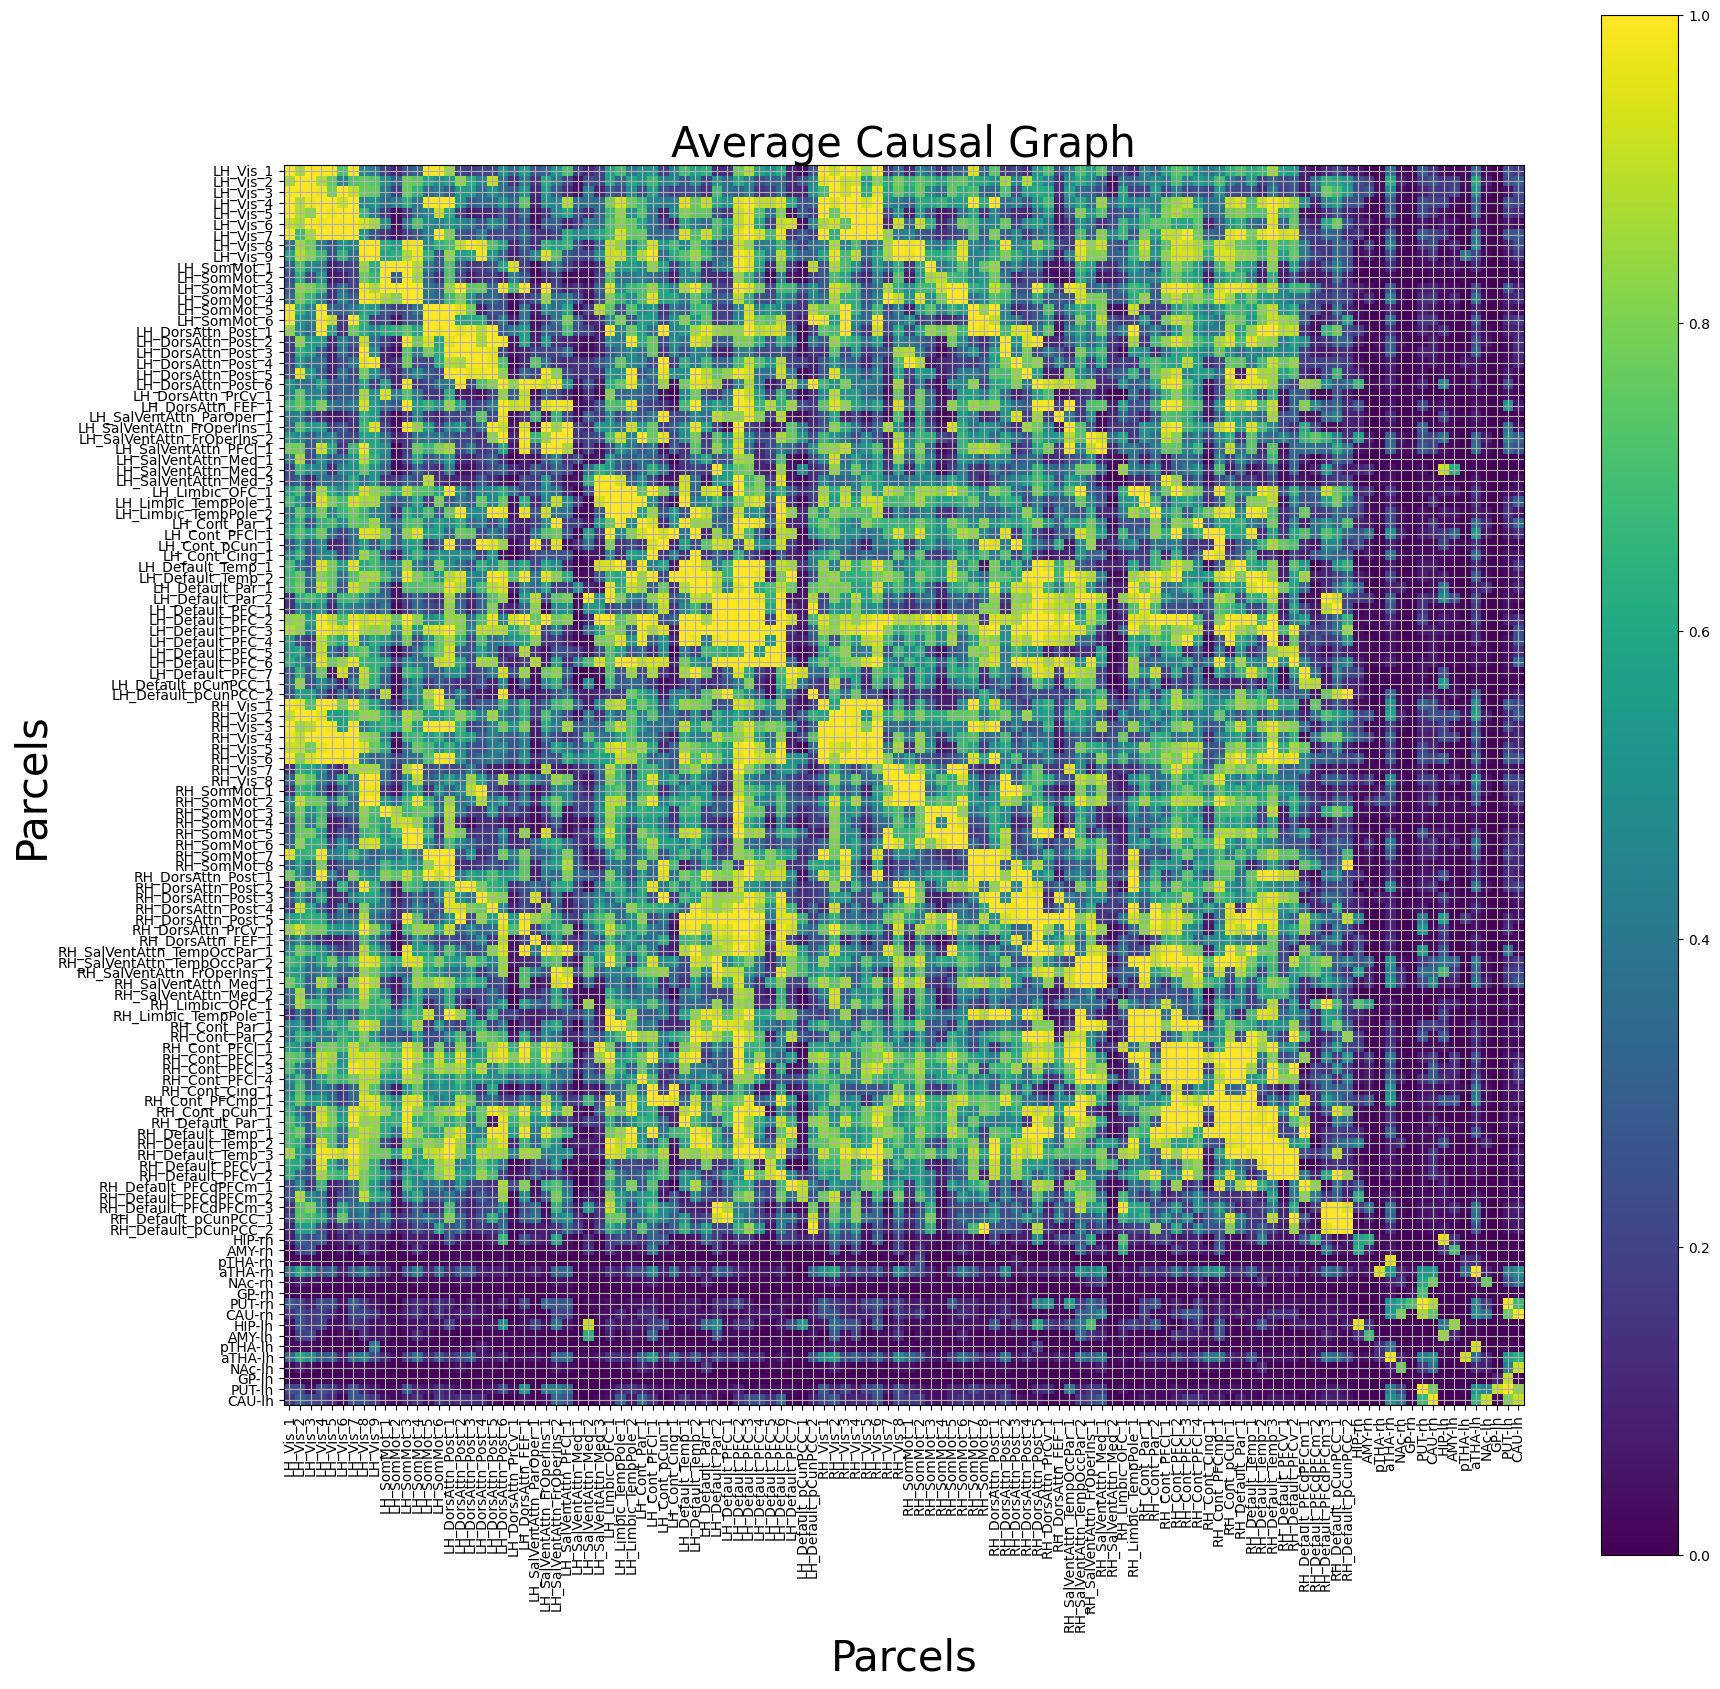

In [52]:
avg_fc_graph = np.mean(np.array(fc_binarized_all), axis = 0)
avg_calltif_graph = np.mean(np.array(hcp_rest_all_graphs), axis = 0)

plt.figure(figsize = (20,20))
p = plt.imshow(avg_fc_graph)

plt.xlabel('Parcels', fontsize = 30)
plt.ylabel('Parcels', fontsize = 30)

plt.title('Average Functional Graph', fontsize = 30)
plt.grid()

p = plt.xticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 90)
p = plt.yticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 0)
plt.colorbar()

plt.figure(figsize = (20,20))
p = plt.imshow(avg_calltif_graph)
plt.colorbar()
plt.xlabel('Parcels', fontsize = 30)
plt.ylabel('Parcels', fontsize = 30)
plt.title('Average Causal Graph', fontsize = 30)
plt.grid()

p = plt.xticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 90)
p = plt.yticks(np.arange(0,num_parcels), labels = parcel_labels, rotation = 0)


### Individual Subjects

In [53]:
is_subset_all_subjects = []
num_edges_in_CG_but_Not_in_FC_all = []
fc_pvalues_of_edges_in_CG_but_Not_in_FC_all = []

percentage_edges_only_in_CG_all = []
percentage_of_edges_in_both = []

for s in range(0, num_subjects_ready):

    is_subset = 1
    num_edges_in_CG = 0
    num_edges_in_both = 0
    for i in range(0, num_parcels):
        for j in range(0, num_parcels):

            x = hcp_rest_all_graphs[s][i,j]
            # x = each_lag_graph_all[0][s][i,j]
            y = fc_binarized_all[s][i,j]

            if (y == 0) and (x == 1):
                is_subset = 0
                num_edges_in_CG = num_edges_in_CG +1

                fc_pvalues_of_edges_in_CG_but_Not_in_FC_all.append(functional_connectivity_p_values[s][i,j])

            if (y == 1) and (x == 1):
                num_edges_in_both = num_edges_in_both +1

    is_subset_all_subjects.append(is_subset)
    num_edges_in_CG_but_Not_in_FC_all.append(num_edges_in_CG)

    percentage_edges_only_in_CG_all.append(num_edges_in_CG/np.sum(hcp_rest_all_graphs[s]))
    percentage_of_edges_in_both.append(num_edges_in_both/np.sum(fc_binarized_all[s]))

In [54]:
print('Number of subject that gave CG graph as a subset of FC graph:',np.sum(is_subset_all_subjects))

Number of subject that gave CG graph as a subset of FC graph: 0


percentage_edges_only_in_CG_all: 0.057536772202726974


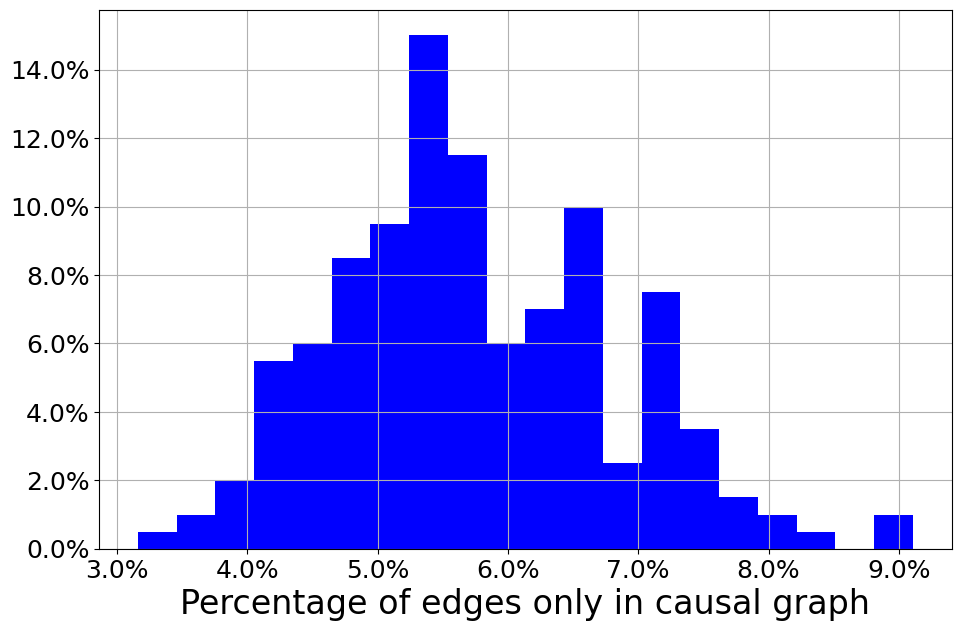

In [55]:
plt.figure(figsize = (11,7))
plt.hist(percentage_edges_only_in_CG_all, 20, weights=np.ones(len(percentage_edges_only_in_CG_all)) / len(percentage_edges_only_in_CG_all), color = 'blue')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Percentage of edges only in causal graph', fontsize = 24)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)

print('percentage_edges_only_in_CG_all:', np.mean(percentage_edges_only_in_CG_all))    

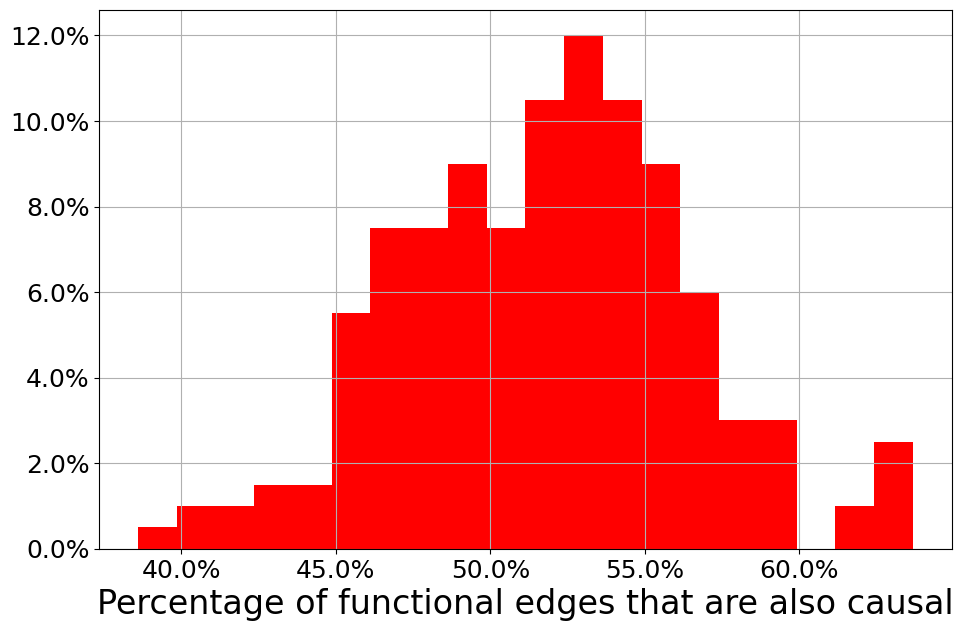

In [56]:
plt.figure(figsize = (11,7))
plt.hist(percentage_of_edges_in_both, 20, weights=np.ones(len(percentage_of_edges_in_both)) / len(percentage_of_edges_in_both), color = 'red')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Percentage of functional edges that are also causal', fontsize = 24)
plt.yticks(fontsize = 18)
p = plt.xticks(fontsize = 18)

## Consistency (correlation) across subjects: Compare Functional and Causal Graphs

### Functional Graphs

In [57]:
fc_pearsonr_statistics_degree_subject_pairs = np.zeros((num_subjects_ready, num_subjects_ready))
fc_pearsonr_pvalue_degree_subject_pairs = np.zeros((num_subjects_ready, num_subjects_ready))

for s1 in range(num_subjects_ready):
    for s2 in range(num_subjects_ready):
    
        # temp = scipy.stats.pearsonr(degree_fc_parcel_level_all[s1], degree_fc_parcel_level_all[s2])
        temp = scipy.stats.pearsonr(fc_binarized_all[s1].flatten(), fc_binarized_all[s2].flatten())

        fc_pearsonr_statistics_degree_subject_pairs[s1,s2] = temp[0]
        fc_pearsonr_pvalue_degree_subject_pairs[s1,s2] = temp[1]

### Causal Graph

In [58]:
pearsonr_statistics_degree_subject_pairs = np.zeros((num_subjects_ready, num_subjects_ready))
pearsonr_pvalue_degree_subject_pairs = np.zeros((num_subjects_ready, num_subjects_ready))

for s1 in range(num_subjects_ready):
    for s2 in range(num_subjects_ready):
    
        temp = scipy.stats.pearsonr(hcp_rest_all_graphs[s1].flatten(), hcp_rest_all_graphs[s2].flatten())

        pearsonr_statistics_degree_subject_pairs[s1,s2] = temp[0]
        pearsonr_pvalue_degree_subject_pairs[s1,s2] = temp[1]

2.035442268879085
WilcoxonResult(statistic=797014561.0, pvalue=0.0)


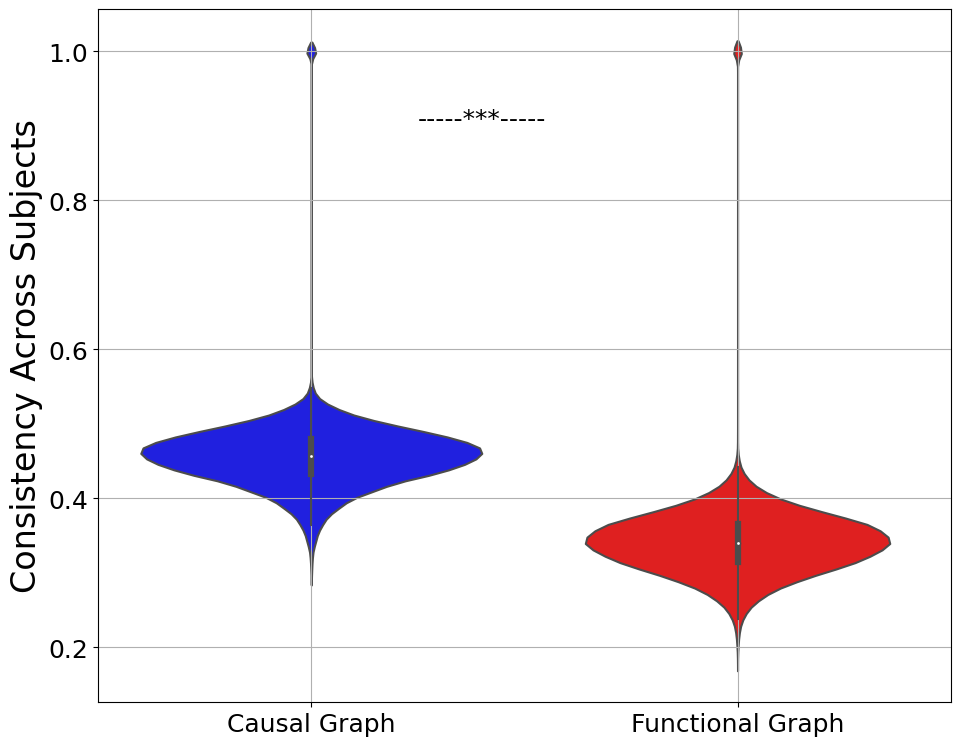

In [59]:
plt.figure(figsize = (11,9))
violin_parts = sns.violinplot([pearsonr_statistics_degree_subject_pairs.flatten(), fc_pearsonr_statistics_degree_subject_pairs.flatten()], showmedians = True, showextrema = True, palette=['blue','red'] )
plt.grid()
plt.ylabel('Consistency Across Subjects', fontsize = 24)
plt.xticks(np.arange(0,2), labels = ['Causal Graph','Functional Graph'], rotation = 'horizontal',fontsize = 18)
h = plt.yticks(fontsize = 18)
test_degree = scipy.stats.wilcoxon(pearsonr_statistics_degree_subject_pairs.flatten(), fc_pearsonr_statistics_degree_subject_pairs.flatten(), alternative='greater')

pvalue = '-----***-----'
y_position = 0.9
plt.text(x=0.25, y=y_position, s=pvalue, fontsize=18)

causal_functional_consistency_effect_size = funcs.compute_cohens_d(pearsonr_statistics_degree_subject_pairs.flatten(),fc_pearsonr_statistics_degree_subject_pairs.flatten())

print(causal_functional_consistency_effect_size)
print(test_degree)
